# <span style="color:IndianRed"> TP 3: Hasting-Metropolis (and Gibbs) samplers </span>

Anne Gagneux

# <span style="color:Gray"> Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM </span>

In [2]:
import numpy as np
from scipy.stats import invwishart, norm, uniform, multivariate_normal
import matplotlib.pyplot as plt
from tqdm import trange
import seaborn as sns

### Compute trajectories

In [1636]:
def trajectory(xi,tau,t0,v0,t_obs,N, p0 =0 ): 
    xi = xi.reshape(-1,1)
    tau = tau.reshape(-1,1)
    return p0 + v0 * np.exp(xi) * (t_obs - t0 - tau)

def trajectory_i(xi_i,tau_i, t0,v0,p0=0 ):
    return p0 + v0 * np.exp(xi_i) * (t[i] - t0 - tau_i)

def trajectory_pop(zz, t0,v0,p0=0 ):
    xi = np.copy(zz[:N]).reshape(-1,1)
    tau = np.copy(zz[N:2*N]).reshape(-1,1)
    return p0 + v0 * np.exp(xi) * (t - t0 - tau)

### Choice of fixed parameters

In [1827]:
# fixed parameters 
v, m = 2, 3
t0_bar_bar = 2
v0_bar_bar = 3
sigma_t0 = 0.5
sigma_v0 = 0.5
s_t0 = 0.1
s_v0 = 0.1
K = 40
N = 50
t = np.array([np.arange(K) for i in range (N)])

### Notations

$$ \theta = (\sigma_\xi, \sigma_\tau, \sigma, \bar t_0, \bar v_0) $$
$$ z = (\xi_i, \tau_i,t_0,  v_0) $$

## Generate data

In [1828]:
class SyntheticDataGenerator:

    def __init__(self):
        return None
    
    def generate_theta(self):
        self.theta = np.zeros(5)
        distrib_sigmas = invwishart(m,v)
        self.theta[0] = np.sqrt(distrib_sigmas.rvs())
        self.theta[1] = np.sqrt(distrib_sigmas.rvs())
        self.theta[2] = np.sqrt(distrib_sigmas.rvs())
        self.theta[3] = norm.rvs(loc=t0_bar_bar, scale=s_t0)
        self.theta[4] = norm.rvs(loc=v0_bar_bar, scale=s_v0)
    
    def generate_z(self):
        self.z = np.zeros(2*N+2)
        self.z[:N] = norm.rvs(scale = self.theta[0], size = N)
        self.z[N:2*N] = norm.rvs(scale = self.theta[1], size = N)
        self.z[-2] = norm.rvs(loc=self.theta[3], scale=sigma_t0)
        self.z[-1] = norm.rvs(loc=self.theta[4], scale=sigma_v0)
        
    def generate_data(self):
        self.generate_theta()
        self.generate_z()
        xi = self.z[:N]
        tau = self.z[N:2*N]
        t0 = self.z[-2]
        print(t0.shape)
        v0 = self.z[-1]
        self.y = trajectory(xi,tau,t0,v0, t, N) + multivariate_normal.rvs(cov= self.theta[2]**2 * np.eye(K), size = N)
        

In [1829]:
data = SyntheticDataGenerator()
data.generate_data()

()


### True $\theta$

In [1830]:
data.theta

array([0.86639432, 0.77645097, 0.67752977, 1.96249515, 2.95502771])

### Generated $(t_0,v_0)$

In [1831]:
data.z[-2],data.z[-1]

(1.579230865999015, 2.0917010639085416)

### Observations $(y_{i,j})$

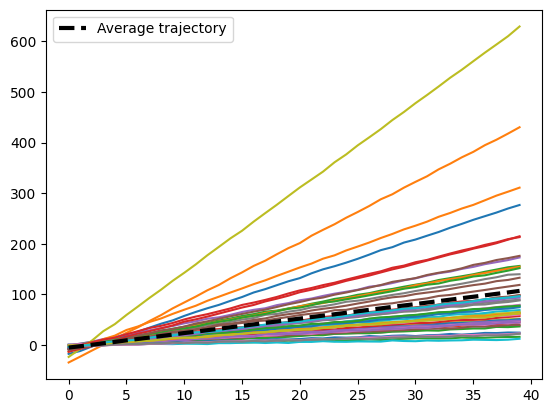

In [1832]:
for i in range(N):
    plt.plot(t[i],data.y[i,:])
plt.plot(t[0],data.y.mean(axis=0), linewidth=3, color = 'k',linestyle='dashed',label="Average trajectory")
plt.legend()

## Algorithme 1 : Hasting-Metropolis Sampler

In [1833]:
def get_psi(theta):
    psi = np.zeros(5)
    psi[:3] = -1/(2*theta[:3]**2)
    psi[3] = theta[3] / sigma_t0**2
    psi[4] = theta[4] / sigma_v0**2
    return psi
    
def get_s(y,xi,tau,t0,v0):
    S = np.zeros(5)
    yy = np.array(y)
    S[0] = (xi**2).sum()
    S[1] = (tau**2).sum()
    S[2] = ((yy-trajectory(xi,tau,t0,v0,t,N))**2).sum()
    S[3] = t0
    S[4] = v0
    return S

def compute_phi2(t0,v0):
    return (-t0**2/(2*sigma_t0**2)) + (-v0**2/(2*sigma_v0**2)) 

In [1834]:
class HastingMetropolisSampler:
    
    def __init__(self,z_init, theta, y_obs, sigmaProp = 0.001, maxSteps = 50000):
        self.theta = np.array(theta)
        self.xi = np.array(z_init[:N])
        self.tau = np.array(z_init[N:2*N])
        self.t0 = z_init[-2]
        self.v0 = z_init[-1]
        self.sigma_prop = sigmaProp
        self.max_steps = maxSteps
        self.nstep = 0
        self.y = np.array(y_obs)
        self.n_accepted = 0
        self.z_list = []
    

    
    def step(self):

        new_xi = np.array(self.xi)+np.random.multivariate_normal(mean =np.zeros(N), cov = self.sigma_prop **2 *np.eye(N))
        new_tau = np.array(self.tau) + np.random.multivariate_normal(mean =np.zeros(N), cov = self.sigma_prop **2 *np.eye(N))
        new_t0 = self.t0+np.random.randn() * self.sigma_prop
        new_v0 = self.v0+np.random.randn() * self.sigma_prop
        new_pi = compute_phi2(new_t0,new_v0) + get_s(self.y, new_xi,new_tau,new_t0,new_v0) @ get_psi(self.theta).T 
        a = new_pi - self.pi
        u = np.random.rand()
        if np.log(u) <= a:
            self.n_accepted += 1
            self.xi =new_xi
            self.tau=new_tau
            self.t0=new_t0
            self.v0 =new_v0
            self.pi = new_pi
        self.z_list.append([self.xi,self.tau,self.t0,self.v0])
            
    
    def train(self):
        
        self.pi = compute_phi2(self.t0,self.v0) + get_s(self.y, self.xi,self.tau,self.t0,self.v0) @ get_psi(self.theta).T
        for n in range(self.max_steps):
            self.step()
            self.nstep +=1
        print("Acceptation rate", self.n_accepted/self.nstep)
    

In [1835]:
HM = HastingMetropolisSampler(z_init = np.zeros(2*N+2), theta = data.theta, y_obs = data.y)

In [ ]:
HM.train()

/var/folders/qx/p01hbgjx6cq8nj27bsc_rb4c0000gn/T/ipykernel_966/1280565945.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(range(HM.nstep), np.array(HM.z_list)[:,-2],label = r"Sampled $t_0$" )


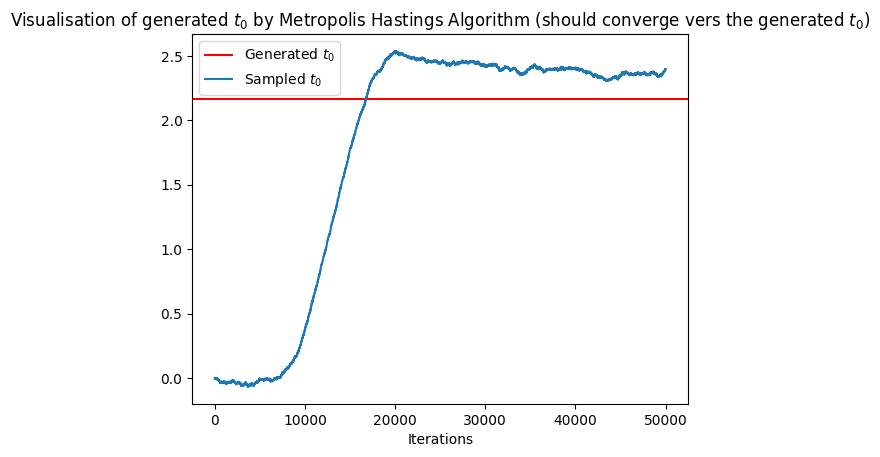

In [1684]:
plt.axhline(y=data.z[-2], color='r', linestyle='-', label = r"Generated $t_0$")
plt.plot(range(HM.nstep), np.array(HM.z_list)[:,-2],label = r"Sampled $t_0$" )
plt.xlabel("Iterations")
plt.title(r"Visualisation of generated $t_0$ by Metropolis Hastings Algorithm (should converge vers the generated $t_0$)")
plt.legend()

/var/folders/qx/p01hbgjx6cq8nj27bsc_rb4c0000gn/T/ipykernel_966/3263343192.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(range(HM.nstep), np.array(HM.z_list)[:,-1] , label = r"Sampled $v_0$" )


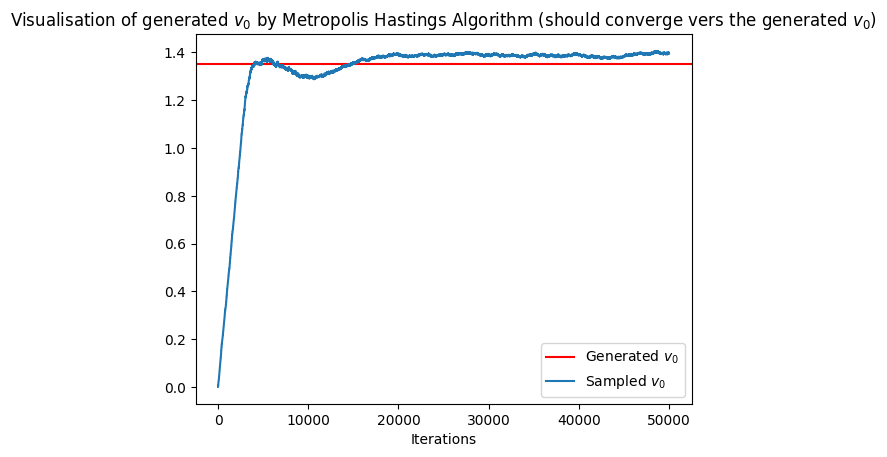

In [1685]:
plt.axhline(y=data.z[-1], color='r', linestyle='-', label = r"Generated $v_0$")
plt.plot(range(HM.nstep), np.array(HM.z_list)[:,-1] , label = r"Sampled $v_0$" )
plt.xlabel("Iterations")
plt.title(r"Visualisation of generated $v_0$ by Metropolis Hastings Algorithm (should converge vers the generated $v_0$)")
plt.legend()

Text(0.5, 1.0, '$\\xi_i$')

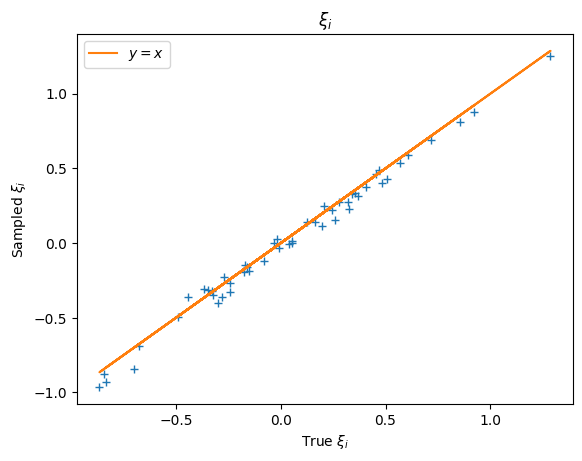

In [1687]:
plt.plot(data.z[:N],HM.xi[:N], '+')
plt.xlabel(r"True $\xi_i$")
plt.ylabel(r"Sampled $\xi_i$")
plt.plot(data.z[:N],data.z[:N], label= r"$y=x$")
plt.legend()
plt.title(r"$\xi_i$")

Text(0.5, 1.0, '$\\tau_i$')

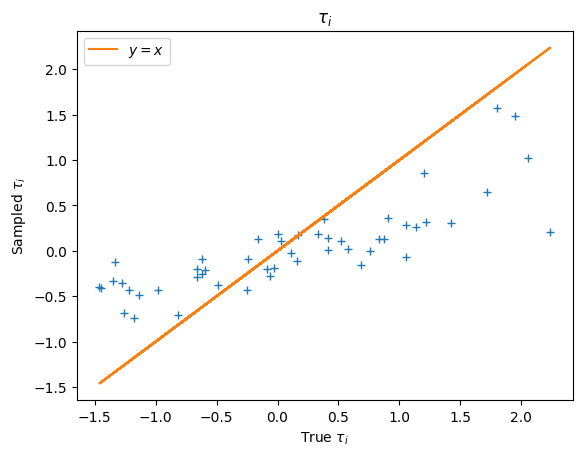

In [1689]:
plt.plot(data.z[N:2*N],HM.tau, '+')
plt.xlabel(r"True $\tau_i$")
plt.ylabel(r"Sampled $\tau_i$")
plt.plot(data.z[N:2*N],data.z[N:2*N],  label= r"$y=x$")
plt.legend()
plt.title(r"$\tau_i$")

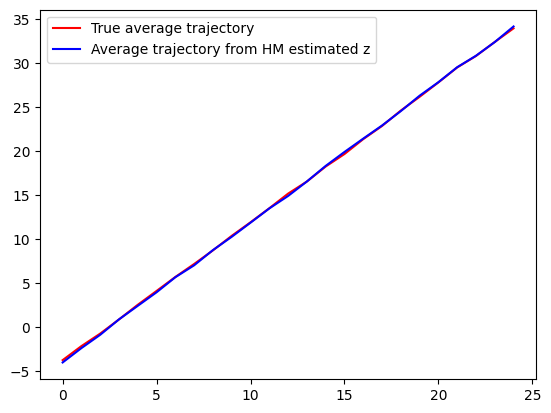

In [1691]:
y_post = trajectory(HM.xi,HM.tau,HM.t0,HM.v0, t, N) + multivariate_normal.rvs(cov= data.theta[2]**2 * np.eye(K), size = N)
plt.plot(t[0], data.y.mean(axis=0), color='r', label = "True average trajectory")
plt.plot(t[0], y_post.mean(axis=0), color='b', label = "Average trajectory from HM estimated z")
plt.legend()

## Algorithme 2: MCMC-SAEM (for curved exponential family)

In [1837]:
def get_theta(S):
    theta = np.zeros(5)
    ss = np.array(S)
    theta[:2] = np.sqrt((v**2+ss[:2])/(N+m+2))
    theta[2] = np.sqrt((v**2+ss[2])/(N*K+m+2))
    theta[3] = (S[3]*s_t0**2 + t0_bar_bar * sigma_t0**2)/(s_t0**2+sigma_t0**2)
    theta[4] = (S[4]*s_v0**2 + v0_bar_bar * sigma_v0**2)/(s_v0**2+sigma_v0**2)
    return theta

In [1850]:
class MCMC_SAEM:
    def __init__(self, theta_init,y_obs, maxSteps = 100):
        self.S = np.zeros(5)
        self.z = np.zeros(2*N+2)
        self.max_steps = maxSteps
        self.burning_steps = self.max_steps //2
        self.y = np.copy(y_obs)
        self.theta = np.copy(theta_init)
        self.nstep = 0
        self.theta_list =[np.copy(theta_init)]
        self.z_list = []
    def compute_epsilon(self):
        if self.nstep <= self.burning_steps:
            return 1
        else:
            return (self.nstep-self.burning_steps)**(-0.5)
            
    
    def step(self):
        ## Simulation
        HM = HastingMetropolisSampler(z_init = self.z, theta = self.theta, y_obs = self.y, sigmaProp= 0.8e-3, maxSteps = 15000)
        HM.train()
        self.z = np.concatenate((HM.xi,HM.tau,[HM.t0],[HM.v0]))
        ## AS
        epsilon = self.compute_epsilon()
        new_S = get_s(self.y, self.z[:N],self.z[N:2*N],self.z[-2],self.z[-1])
        self.S = (1-epsilon) *self.S + epsilon*new_S
        ## Maximization
        self.theta = get_theta(self.S)
        self.theta_list.append(self.theta)
        self.z_list.append(self.z)
        
    def train(self):
        
        for n in trange(self.max_steps):
            
            self.step()
            self.nstep +=1
            
            if n%10 == 0 and n>=1:
                print("n",n,self.theta)
                fig, axs = plt.subplots(2, 3,  figsize=(15, 15))
                axs[0, 0].axhline(y=data.theta[0], color='r', linestyle='-', label = r"True $\sigma_\xi$")
                axs[0, 0].plot(range(self.nstep), [self.theta_list[k][0] for k in range(self.nstep)],label = r"Estimated  $\sigma_\xi$")
                axs[0, 0].legend()
                axs[0, 1].axhline(y=data.theta[1], color='r', linestyle='-', label = r"True $\sigma_\tau$")
                axs[0, 1].plot(range(self.nstep), [self.theta_list[k][1] for k in range(self.nstep)],label = r"Estimated  $\sigma_\tau$")
                axs[0, 1].legend()
                axs[0, 2].axhline(y=data.theta[2], color='r', linestyle='-', label = r"True $\sigma$")
                axs[0, 2].plot(range(self.nstep), [self.theta_list[k][2] for k in range(self.nstep)],label = r"Estimated  $\sigma$")
                axs[0, 2].legend()
                axs[1, 0].axhline(y=data.theta[3], color='r', linestyle='-', label = r"True $\bar t_0$")
                axs[1, 0].plot(range(self.nstep), [self.theta_list[k][3] for k in range(self.nstep)],label = r"Estimated  $\bar t_0$")
                axs[1, 0].legend()
                axs[1, 1].axhline(y=data.theta[4], color='r', linestyle='-', label = r"True $\bar v_0$")
                axs[1, 1].plot(range(self.nstep), [self.theta_list[k][4] for k in range(self.nstep)],label = r"Estimated  $\bar v_0$")
                axs[1, 1].legend()
                plt.title(r"$\theta$")
                plt.show()
            
            

### On initialise $z_0=(0,0,0,0,0)$ et $\theta_0$ aléatoire

In [1851]:
SAEM2 = MCMC_SAEM(theta_init = np.random.rand(5), y_obs = data.y)

In [ ]:
SAEM2.train()

n 4999 [0.81949415 0.67012199 0.68250008 1.98465191 2.96550022]


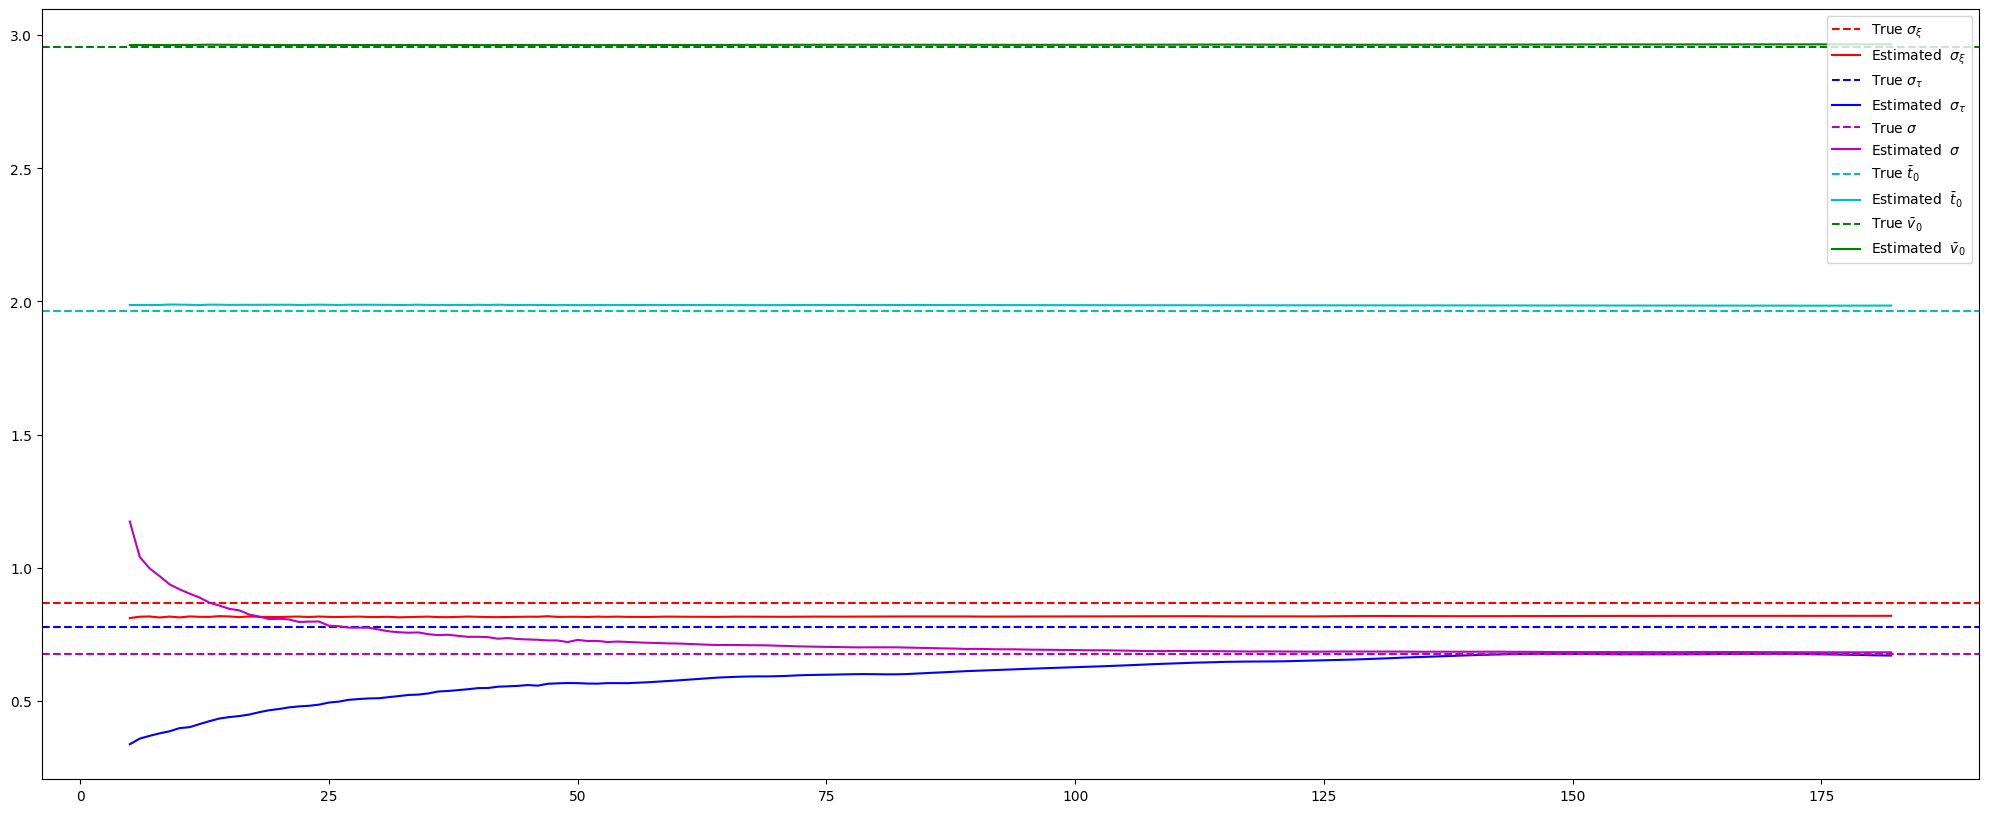

In [1873]:
print("n",n,SAEM2.theta)
plt.figure(figsize=(25, 10))
plt.axhline(y=data.theta[0], color='r', linestyle='--', label = r"True $\sigma_\xi$")
plt.plot(range(5,SAEM2.nstep), [SAEM2.theta_list[k][0] for k in range(5,SAEM2.nstep)],color='r',label = r"Estimated  $\sigma_\xi$")
plt.legend()
plt.axhline(y=data.theta[1], color='b', linestyle='--', label = r"True $\sigma_\tau$")
plt.plot(range(5,SAEM2.nstep), [SAEM2.theta_list[k][1] for k in range(5,SAEM2.nstep)],color='b',label = r"Estimated  $\sigma_\tau$")
plt.legend()
plt.axhline(y=data.theta[2], color='m', linestyle='--', label = r"True $\sigma$")
plt.plot(range(5,SAEM2.nstep), [SAEM2.theta_list[k][2] for k in range(5,SAEM2.nstep)],color='m',label = r"Estimated  $\sigma$")
plt.legend()
plt.axhline(y=data.theta[3], color='c', linestyle='--', label = r"True $\bar t_0$")
plt.plot(range(5,SAEM2.nstep), [SAEM2.theta_list[k][3] for k in range(5,SAEM2.nstep)],color='c',label = r"Estimated  $\bar t_0$")
plt.legend()
plt.axhline(y=data.theta[4], color='g', linestyle='--', label = r"True $\bar v_0$")
plt.plot(range(5,SAEM2.nstep), [SAEM2.theta_list[k][4] for k in range(5,SAEM2.nstep)],color='g',label = r"Estimated  $\bar v_0$")
plt.legend()
plt.show()

Text(0.5, 1.0, '$\\tau_i$ sampled from SAEM $\\theta$ parameters')

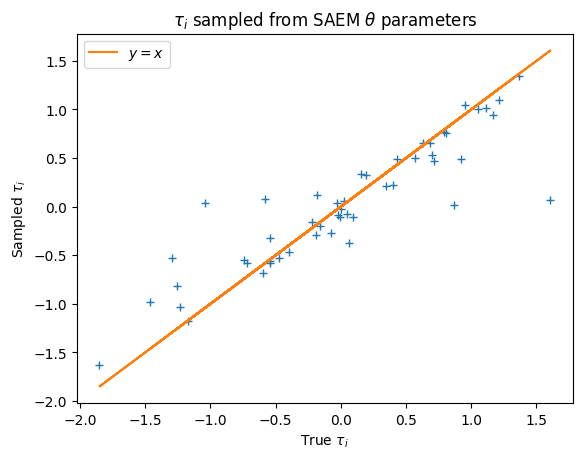

In [1860]:
plt.plot(data.z[N:2*N],np.array(SAEM2.z_list)[-1,N:2*N], '+')
plt.xlabel(r"True $\tau_i$")
plt.ylabel(r"Sampled $\tau_i$ ")
plt.plot(data.z[N:2*N],data.z[N:2*N],  label= r"$y=x$")
plt.legend()
plt.title(r"$\tau_i$ sampled from SAEM $\theta$ parameters")

Text(0.5, 1.0, '$\\xi_i$ sampled from SAEM $\\theta$ parameters')

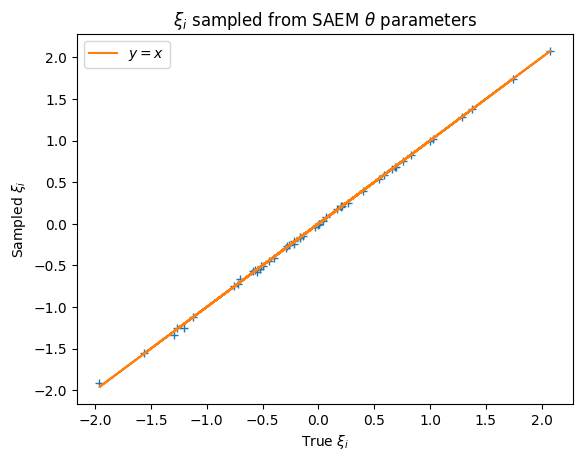

In [1861]:
plt.plot(data.z[:N],np.array(SAEM2.z_list)[-1,:N], '+')
plt.xlabel(r"True $\xi_i$")
plt.ylabel(r"Sampled $\xi_i$ ")
plt.plot(data.z[:N],data.z[:N],  label= r"$y=x$")
plt.legend()
plt.title(r"$\xi_i$ sampled from SAEM $\theta$ parameters")

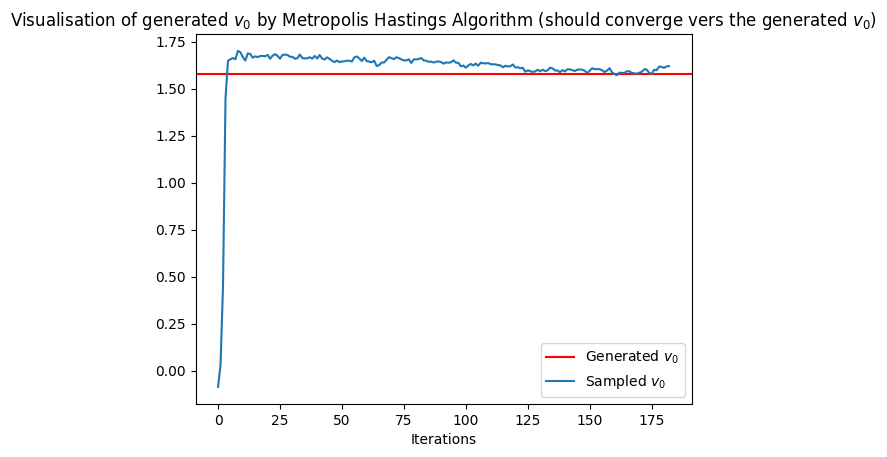

In [1862]:
plt.axhline(y=data.z[-2], color='r', linestyle='-', label = r"Generated $v_0$")
plt.plot(range(SAEM2.nstep), np.array(SAEM2.z_list)[:,-2] , label = r"Sampled $v_0$" )
plt.xlabel("Iterations")
plt.title(r"Visualisation of generated $v_0$ by Metropolis Hastings Algorithm (should converge vers the generated $v_0$)")
plt.legend()

## Algorithm 3: Gibbs Sampler

We directly update $(t_0)$ and $(v_0)$ at the same time (in the same block) because they are highly correlated.

In [1773]:
from copy import copy
class HM_GibbsSampler:
    
    def __init__(self,z_init, theta, y_obs, sigmaProp = 1e-3, maxSteps = 30000):
        self.theta = np.array(theta)
        self.z = np.array(z_init)
        self.sigma_prop = sigmaProp
        self.max_steps = maxSteps
        self.nstep = 0
        self.y = np.array(y_obs)
        self.z_list = []

    
    def step(self):
        for i in range(N):
            current_xi_i = self.z[i]
            current_tau_i = self.z[i+N]
            new_xi_i = current_xi_i+ self.sigma_prop * np.random.randn()
            new_tau_i = current_tau_i+ self.sigma_prop * np.random.randn()
            current_di = trajectory_i(current_xi_i,current_tau_i, self.z[-2], self.z[-1])
            new_di = trajectory_i(new_xi_i,new_tau_i, self.z[-2], self.z[-1])
            a = (current_xi_i**2- new_xi_i**2)/(2*self.theta[0]**2)+(current_tau_i**2- new_tau_i**2)/(2*self.theta[1]**2)
            a+= ((self.y[i,:]-current_di)**2-(self.y[i,:]-new_di)**2).sum()/(2*self.theta[2]**2)
            u = np.random.rand()
            if np.log(u) <= a:   
                self.z[i] = new_xi_i
                self.z[i+N] = new_tau_i
        current_t0 = self.z[-2]
        current_v0 = self.z[-1]
        new_t0 = current_t0 + self.sigma_prop * np.random.randn()
        new_v0 = current_v0 + self.sigma_prop * np.random.randn()
        current_d = trajectory_pop(self.z, current_t0, current_v0)
        new_d = trajectory_pop(self.z, new_t0, new_v0)

        a = ((current_t0-new_t0)/(sigma_t0**2)) * (0.5-self.theta[3]) + ((current_v0-new_v0)/(sigma_v0**2)) * (0.5-self.theta[4])
        a+= ((self.y-current_d)**2-(self.y-new_d)**2).sum()/(2*self.theta[2]**2)
        
        u = np.random.rand()
        if np.log(u) <= a:
            self.z[-2] = new_t0
            self.z[-1] = new_v0
        self.z_list.append(copy(self.z))

    
    def train(self):
        for n in range(self.max_steps):
            self.step()
            self.nstep +=1

In [1774]:
HMG = HM_GibbsSampler(z_init = np.zeros(2*N+2), theta = data.theta, y_obs = data.y)

In [1775]:
HMG.train()

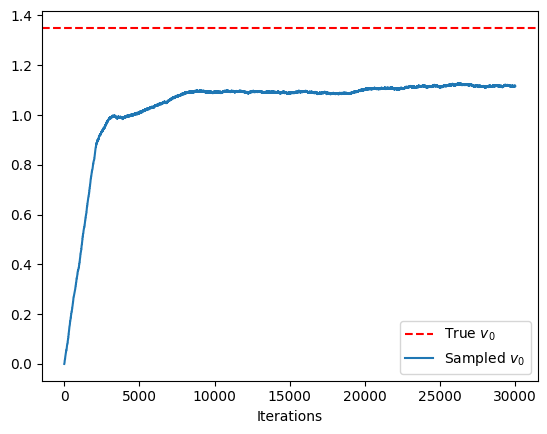

In [1776]:
plt.axhline(y=data.z[-1], color='r', linestyle='--', label = r"True $v_0$")
plt.plot(range(HMG.nstep), [HMG.z_list[k][-1] for k in range(HMG.nstep)],label = r"Sampled $v_0$" )
plt.xlabel("Iterations")
plt.legend()

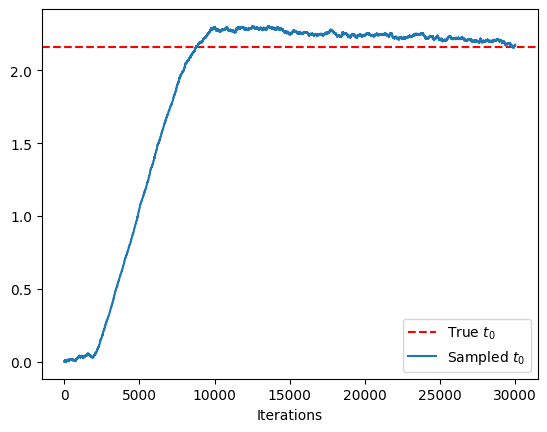

In [1777]:
plt.axhline(y=data.z[-2], color='r', linestyle='--', label = r"True $t_0$")
plt.plot(range(HMG.nstep), [HMG.z_list[k][-2] for k in range(HMG.nstep)],label = r"Sampled $t_0$" )
plt.xlabel("Iterations")
plt.legend()

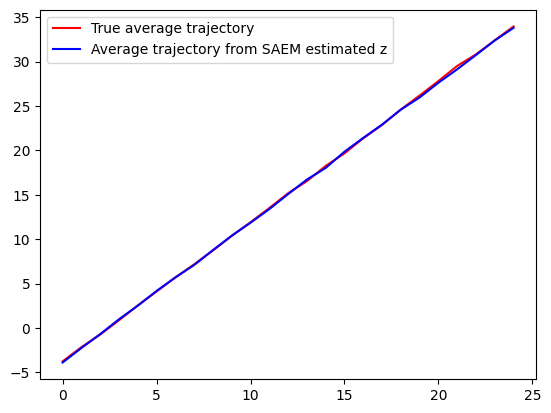

In [1779]:
y_post = trajectory(HMG.z[:N],HMG.z[N:2*N],HMG.z[-2],HMG.z[-1], t, N) + multivariate_normal.rvs(cov= SAEM.theta[2]**2 * np.eye(K), size = N)
plt.plot(t[0], data.y.mean(axis=0), color='r', label = "True average trajectory")
plt.plot(t[0], y_post.mean(axis=0), color='b', label = "Average trajectory from SAEM estimated z")
plt.legend()

Text(0.5, 1.0, '$\\tau_i$')

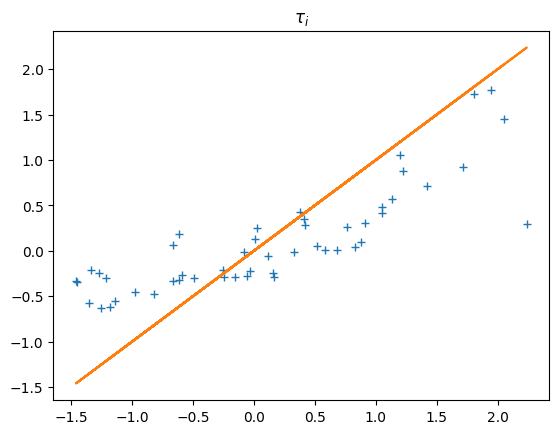

In [1780]:
plt.plot(data.z[N:2*N],HMG.z[N:2*N], '+')
plt.plot(data.z[N:2*N],data.z[N:2*N])
plt.title(r"$\tau_i$")

Text(0.5, 1.0, '$\\xi_i$')

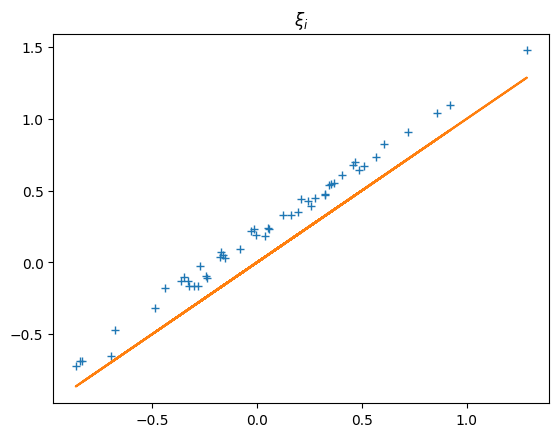

In [1781]:
plt.plot(data.z[:N],HMG.z[:N], '+')
plt.plot(data.z[:N],data.z[:N])
plt.title(r"$\xi_i$")

## HMwG SAEM

On initialise $\theta^{(0)}$ avec $5$ valeurs aléatoires dans $[0,1]$.

In [1875]:
class HMwG_SAEM:
    def __init__(self, theta_init,y_obs, maxSteps = 200):
        self.S = np.zeros(5)
        self.z = np.zeros(2*N+2)
        self.max_steps = maxSteps
        self.burning_steps = self.max_steps //2
        self.y = np.copy(y_obs)
        self.theta_list =[theta_init]
        self.theta = np.copy(theta_init)
        self.nstep = 0
    
    def compute_epsilon(self):
        if self.nstep <= self.burning_steps:
            return 1
        else:
            return (self.nstep-self.burning_steps)**(-0.5)
            
    
    def step(self):
        ## Simulation
        HMG = HM_GibbsSampler(z_init = np.copy(self.z), theta = np.copy(self.theta), y_obs = np.copy(self.y),sigmaProp = 5e-4,maxSteps =10000)
        HMG.train()
        self.z = np.array(HMG.z)
        ## AS
        epsilon = self.compute_epsilon()
        new_S = get_s(self.y, self.z[:N],self.z[N:2*N],self.z[-2],self.z[-1])
        self.S = (1-epsilon) *self.S + epsilon*new_S
        ## Maximization
        self.theta = get_theta(self.S)
        self.theta_list.append(np.array(self.theta))
        
    def train(self):
        for n in trange(self.max_steps):
            #print("n",n,self.theta)
            self.step()
            if n%10 == 0 and n>=1:
                fig, axs = plt.subplots(2, 3,  figsize=(25, 10))
                axs[0, 0].axhline(y=data.theta[0], color='r', linestyle='-', label = r"True $\sigma_\xi$")
                axs[0, 0].plot(range(self.nstep), [self.theta_list[k][0] for k in range(self.nstep)],label = r"Estimated  $\sigma_\xi$")
                axs[0, 0].legend()
                axs[0, 1].axhline(y=data.theta[1], color='r', linestyle='-', label = r"True $\sigma_\tau$")
                axs[0, 1].plot(range(self.nstep), [self.theta_list[k][1] for k in range(self.nstep)],label = r"Estimated  $\sigma_\tau$")
                axs[0, 1].legend()
                axs[0, 2].axhline(y=data.theta[2], color='r', linestyle='-', label = r"True $\sigma$")
                axs[0, 2].plot(range(self.nstep), [self.theta_list[k][2] for k in range(self.nstep)],label = r"Estimated  $\sigma$")
                axs[0, 2].legend()
                axs[1, 0].axhline(y=data.theta[3], color='r', linestyle='-', label = r"True $ \bar t_0$")
                axs[1, 0].plot(range(self.nstep), [self.theta_list[k][3] for k in range(self.nstep)],label = r"Estimated  $\bar t_0$")
                axs[1, 0].legend()
                axs[1, 1].axhline(y=data.theta[4], color='r', linestyle='-', label = r"True $\bar v_0$")
                axs[1, 1].plot(range(self.nstep), [self.theta_list[k][4] for k in range(self.nstep)],label = r"Estimated  $\bar v_0$")
                axs[1, 1].legend()
                plt.show()
            self.nstep +=1
            

In [1876]:
Gibbs_SAEM = HMwG_SAEM(theta_init = np.zeros(5)+0.1, y_obs = data.y)

In [1877]:
print(r"True $\theta$")
print(data.theta)

True $\theta$
[0.86639432 0.77645097 0.67752977 1.96249515 2.95502771]


  5%|████████▎                                                                                                                                                             | 10/200 [01:01<19:18,  6.10s/it]

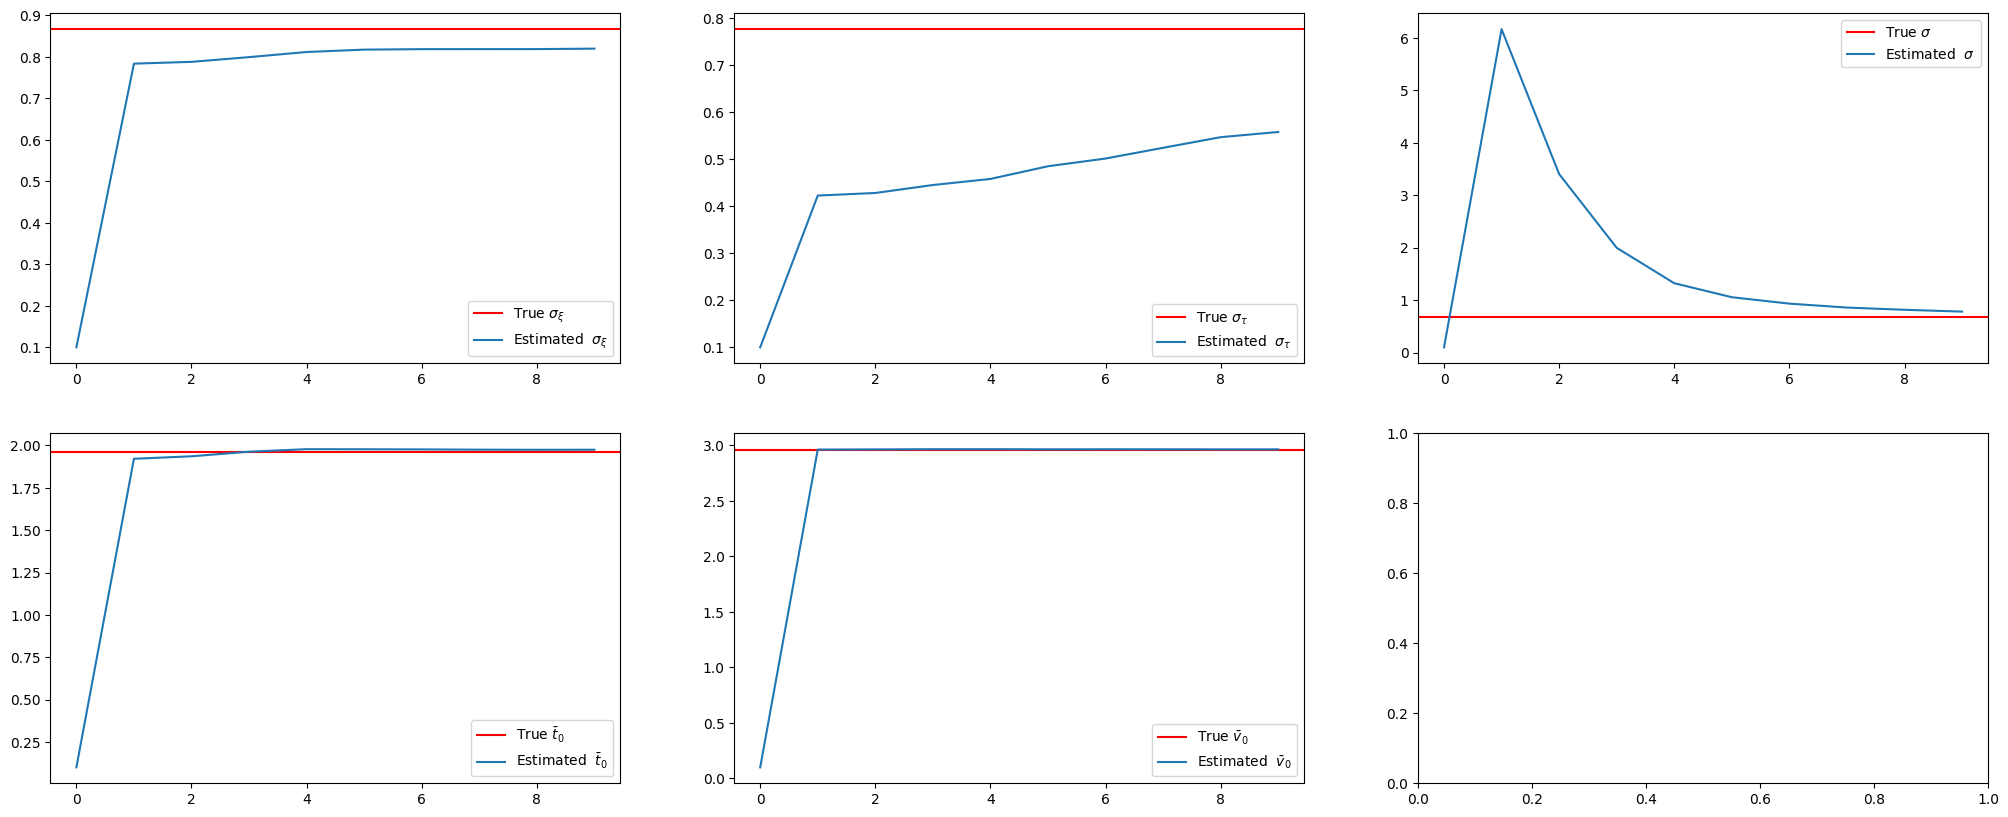

 10%|████████████████▌                                                                                                                                                     | 20/200 [02:02<18:20,  6.12s/it]

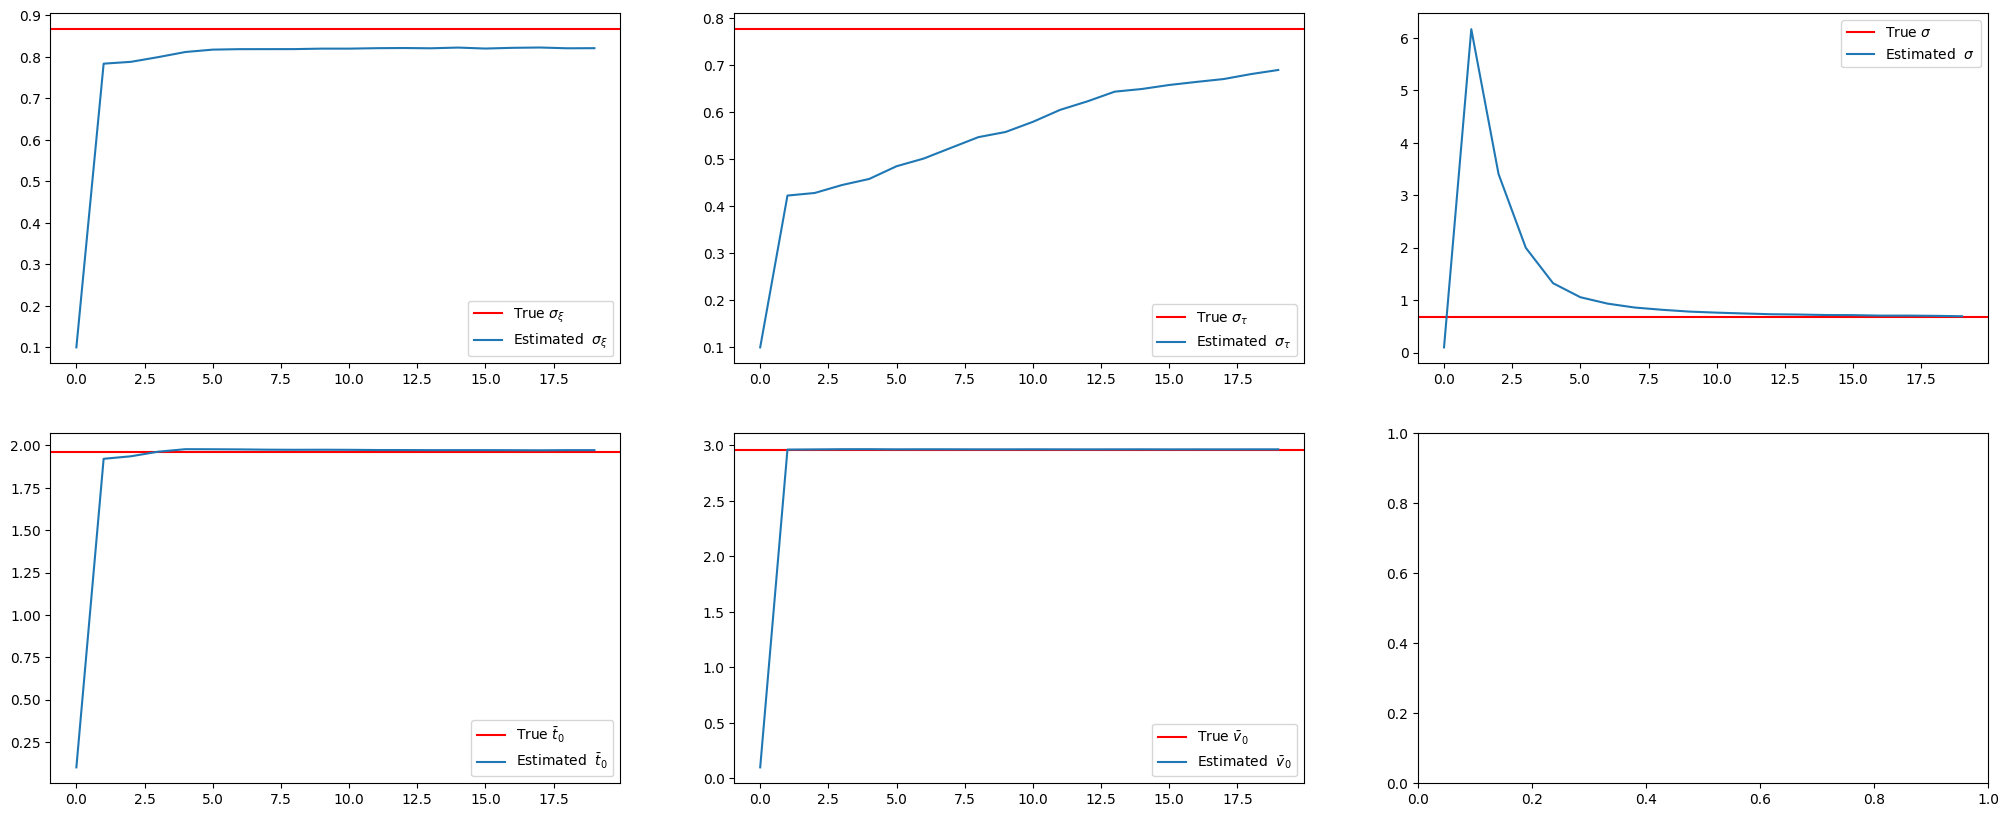

 15%|████████████████████████▉                                                                                                                                             | 30/200 [03:04<17:13,  6.08s/it]

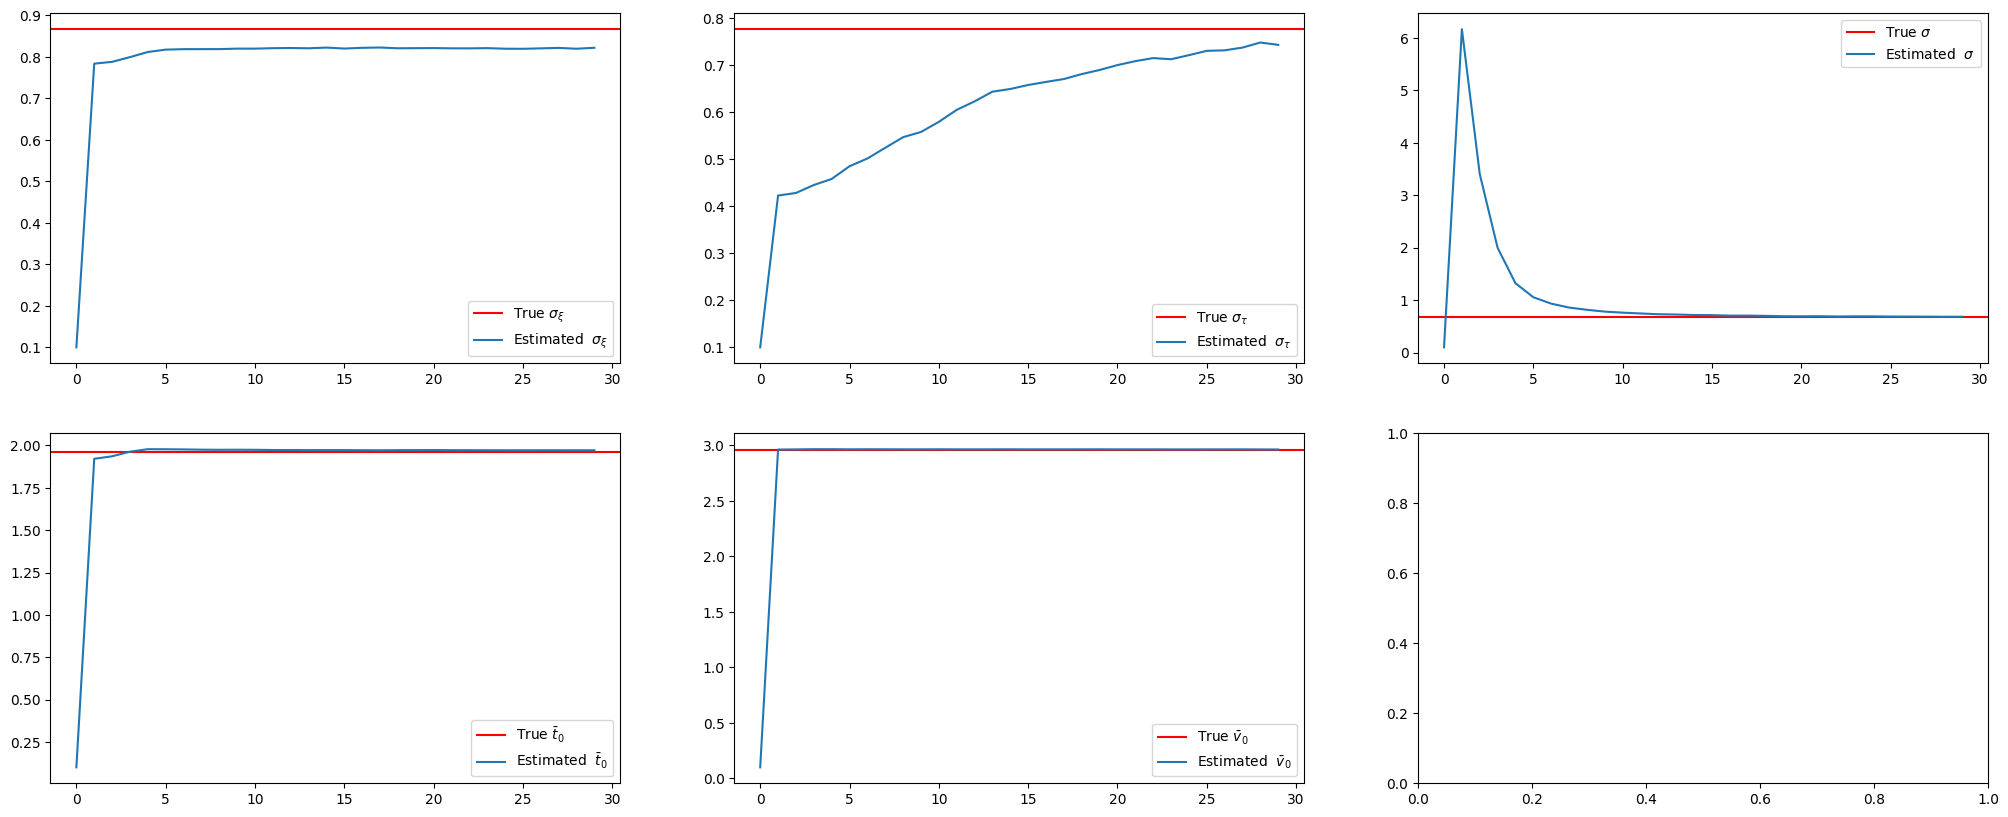

 20%|█████████████████████████████████▏                                                                                                                                    | 40/200 [04:05<16:19,  6.12s/it]

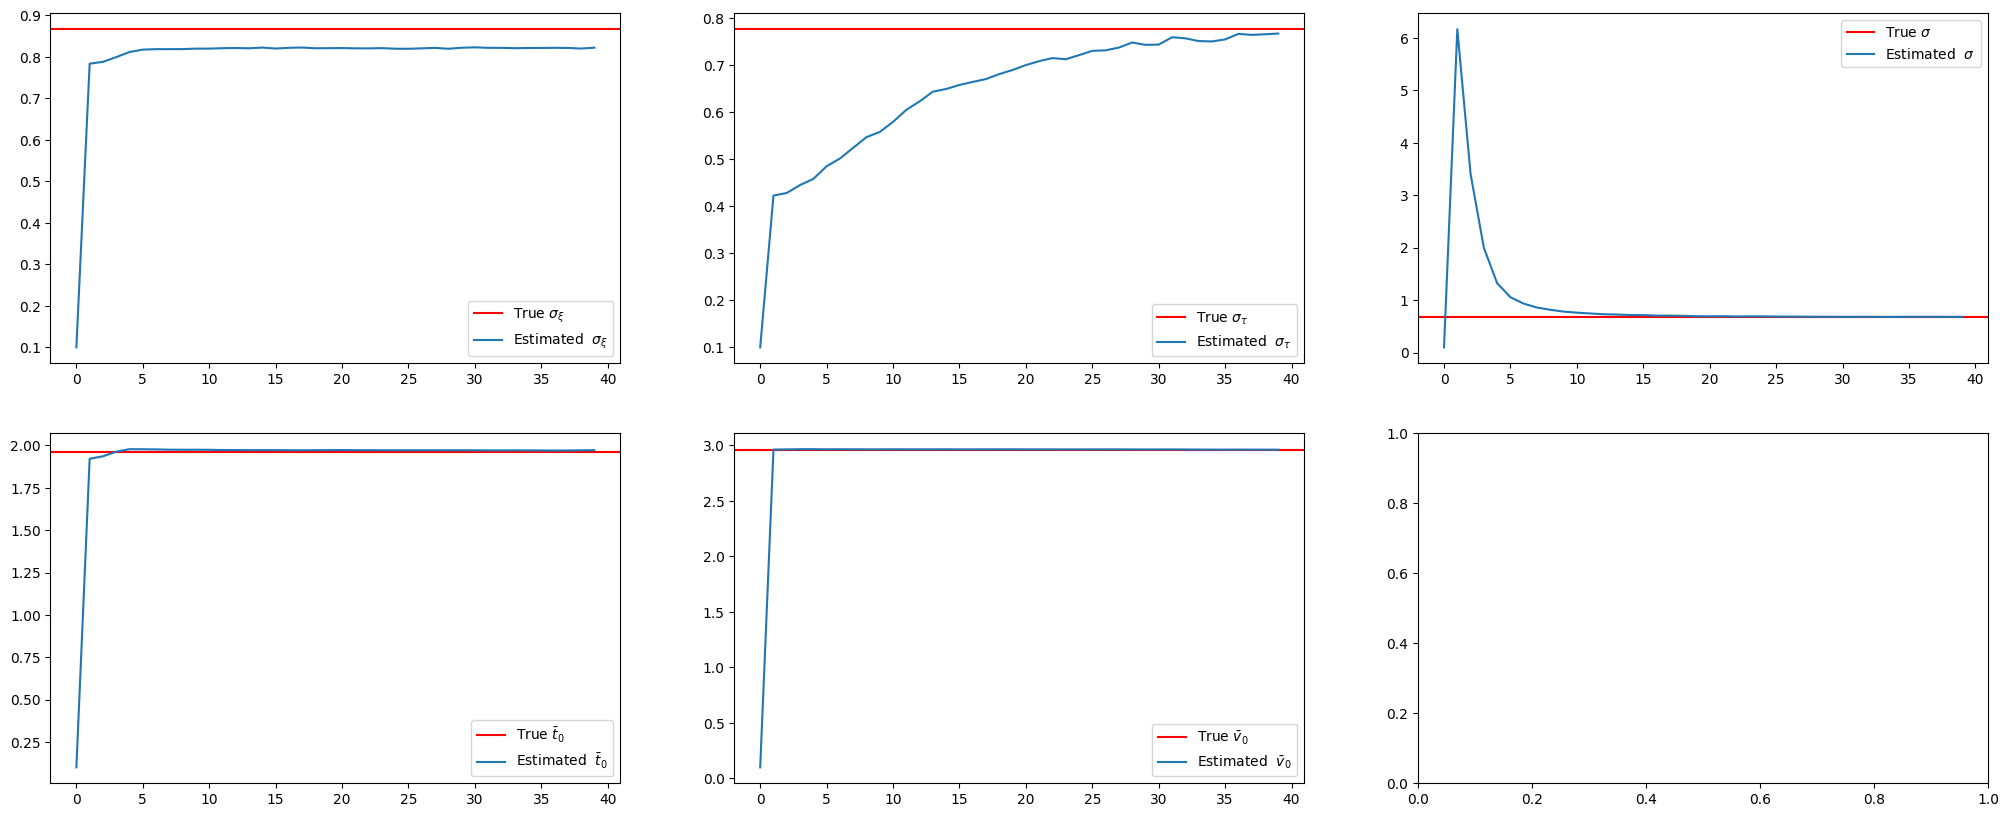

 25%|█████████████████████████████████████████▌                                                                                                                            | 50/200 [05:07<15:22,  6.15s/it]

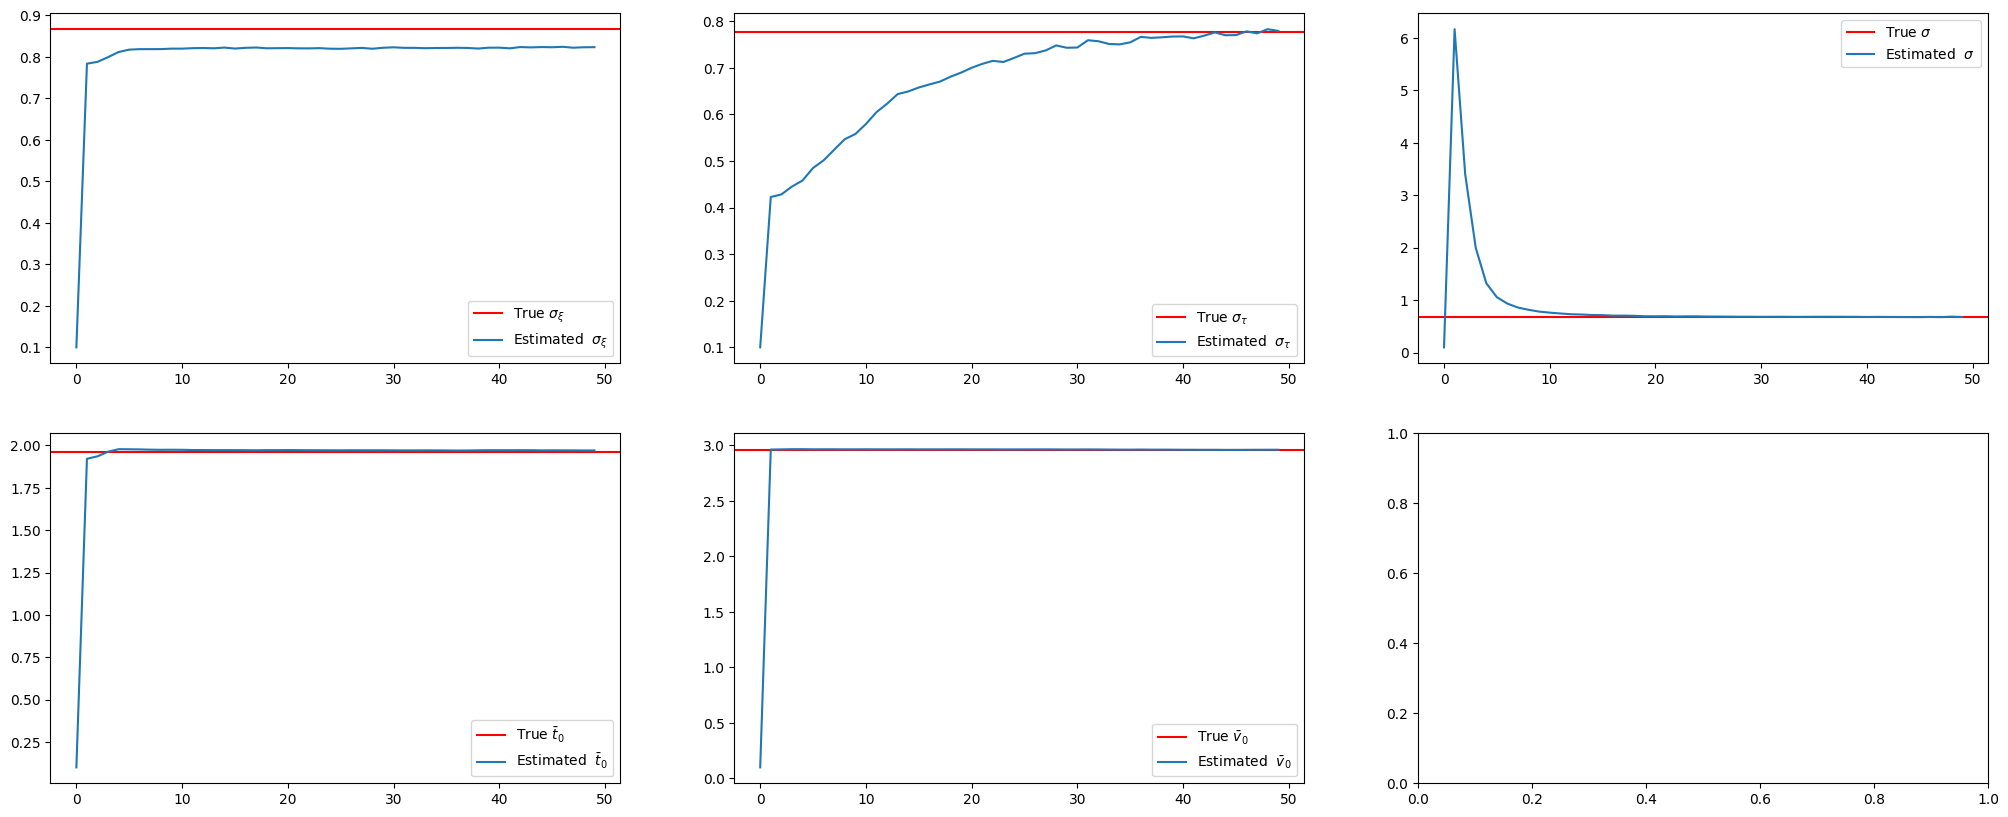

 30%|█████████████████████████████████████████████████▊                                                                                                                    | 60/200 [06:08<14:18,  6.13s/it]

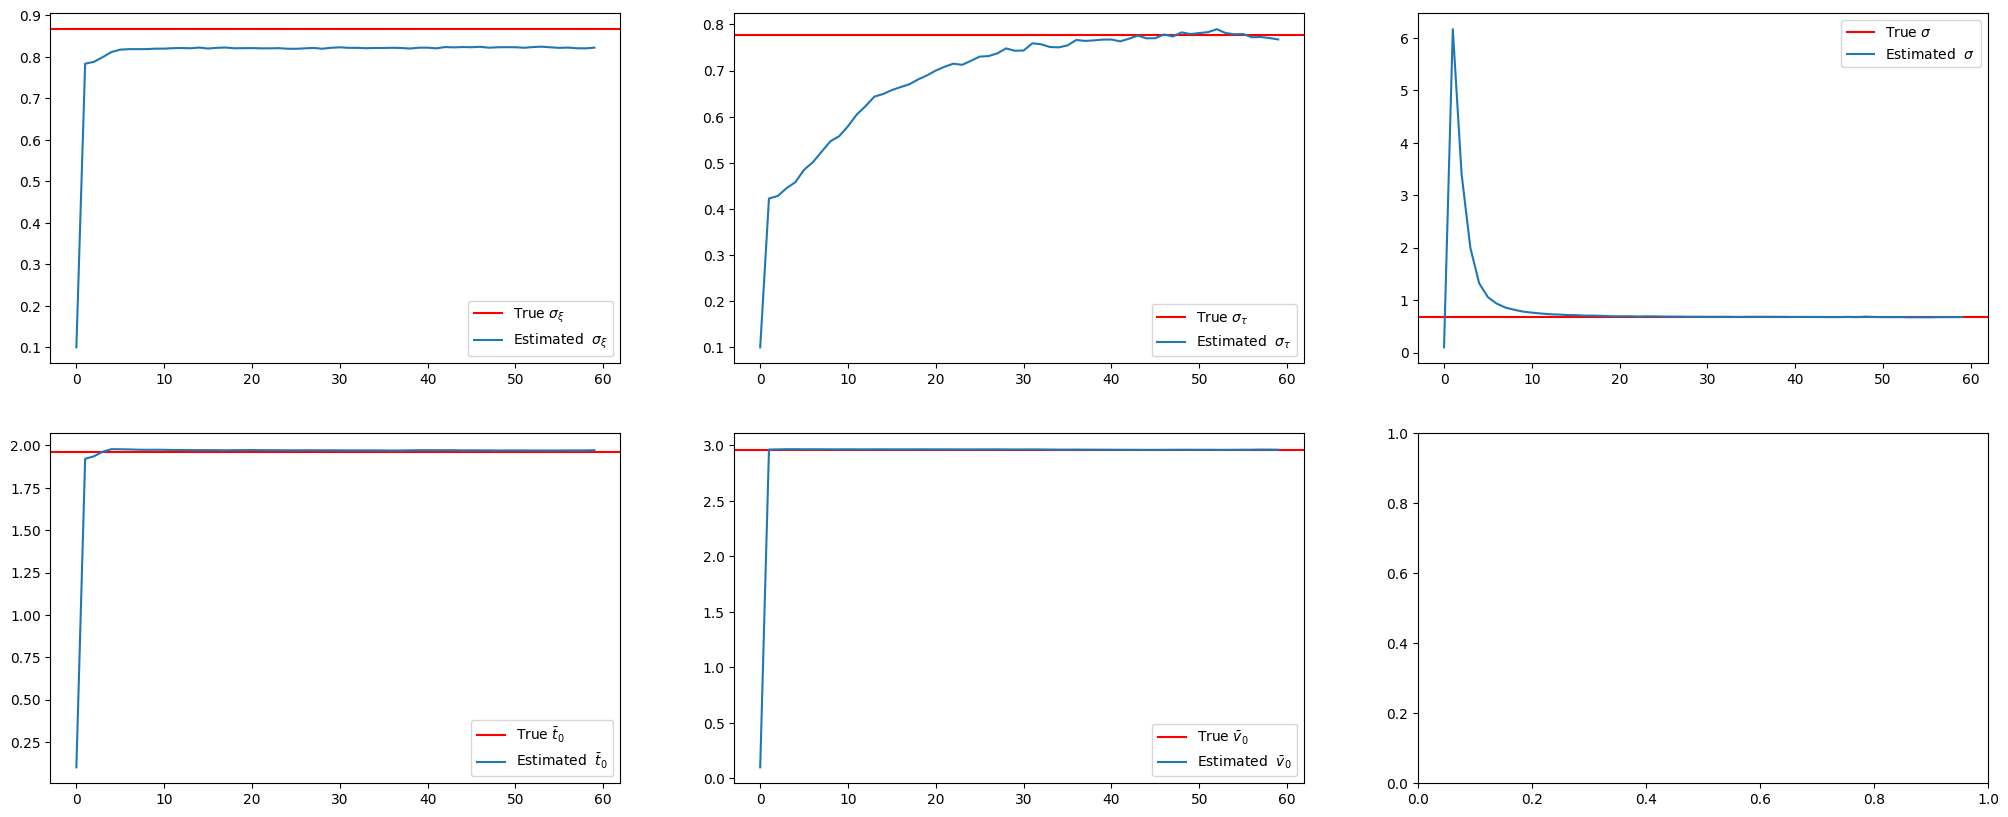

 35%|██████████████████████████████████████████████████████████                                                                                                            | 70/200 [07:11<13:48,  6.37s/it]

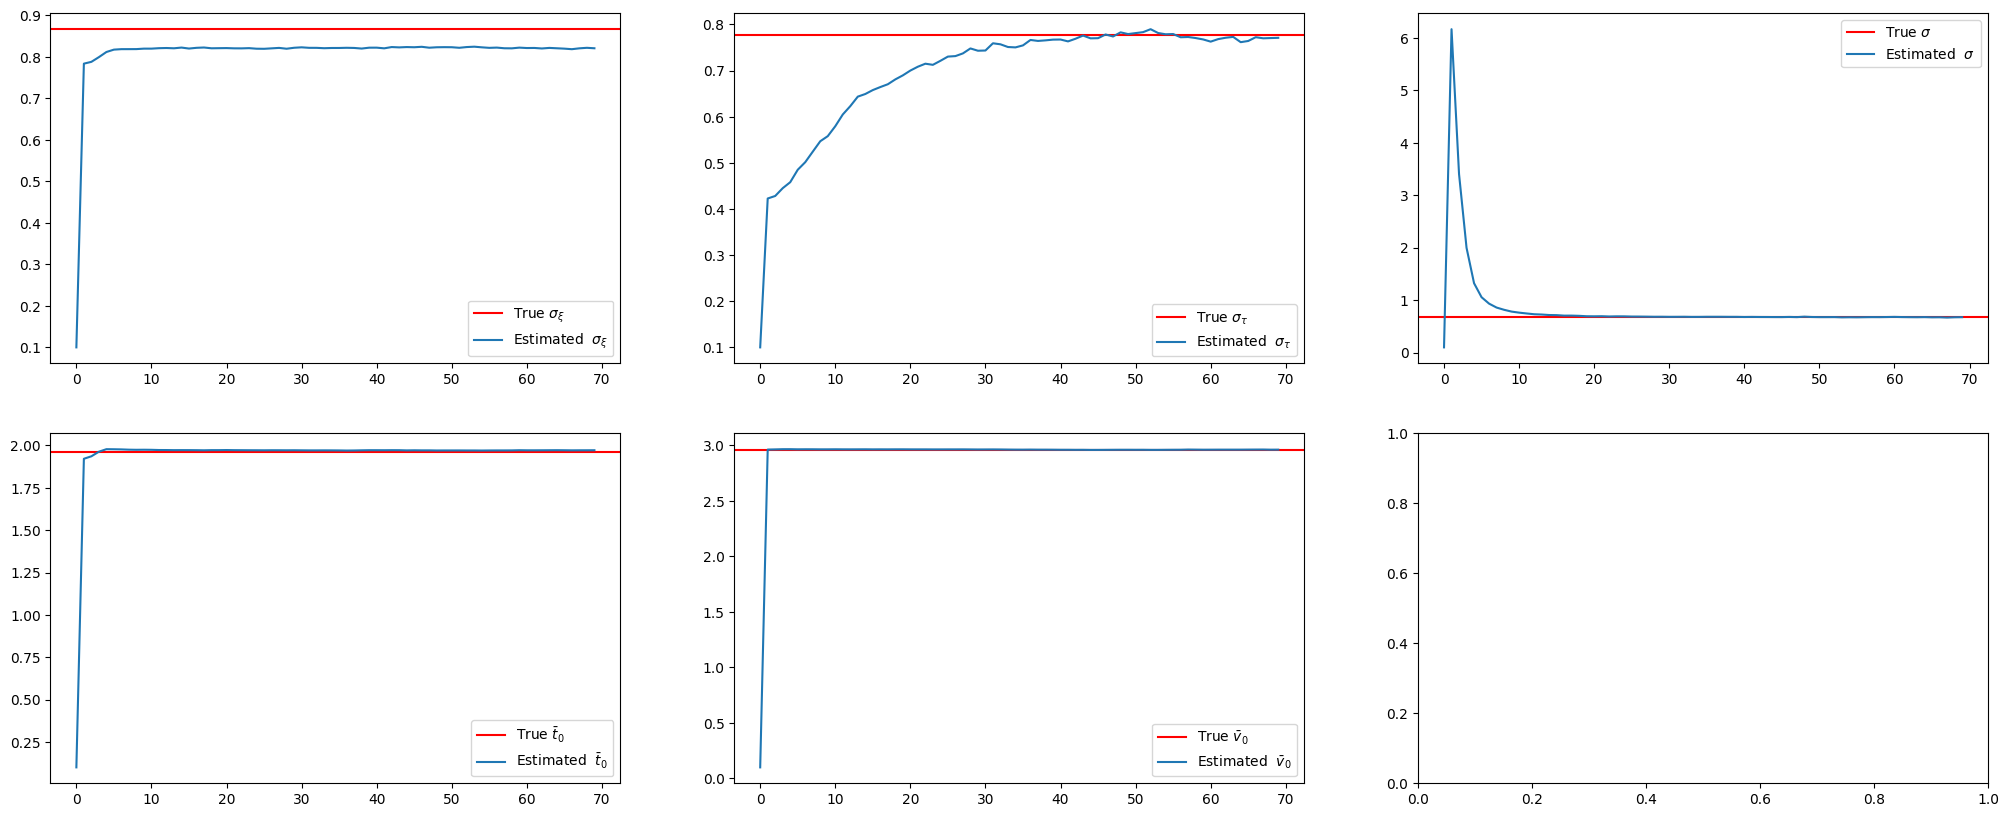

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 80/200 [08:13<12:21,  6.18s/it]

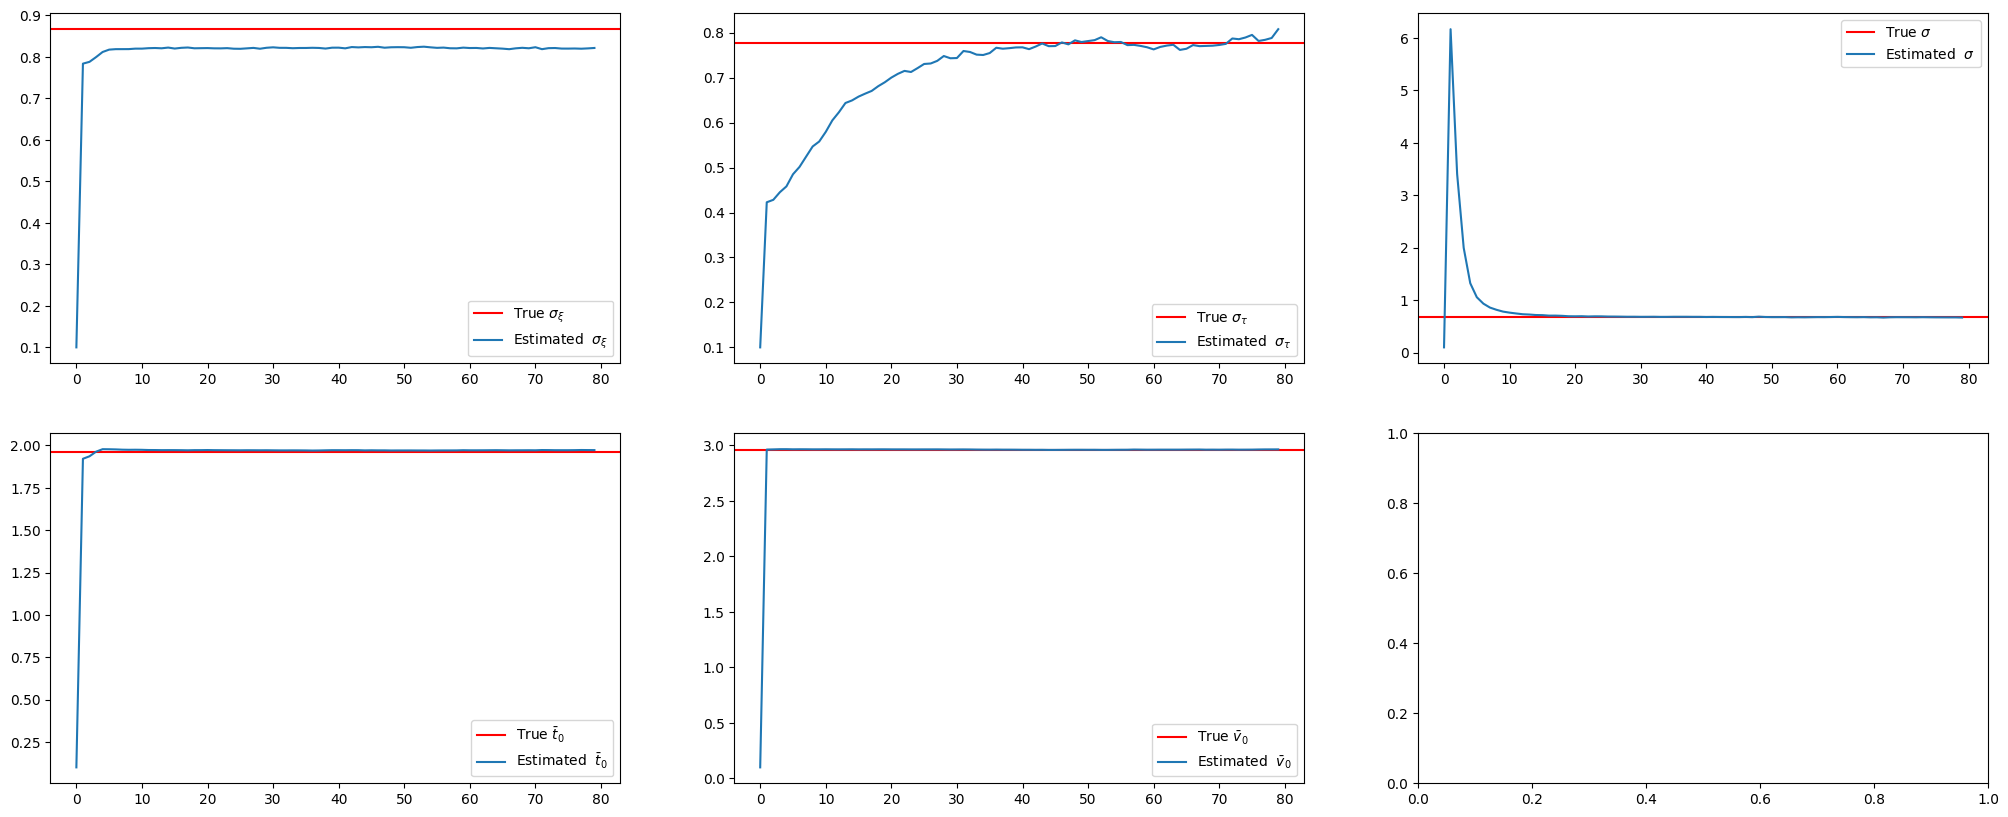

 45%|██████████████████████████████████████████████████████████████████████████▋                                                                                           | 90/200 [09:16<11:23,  6.22s/it]

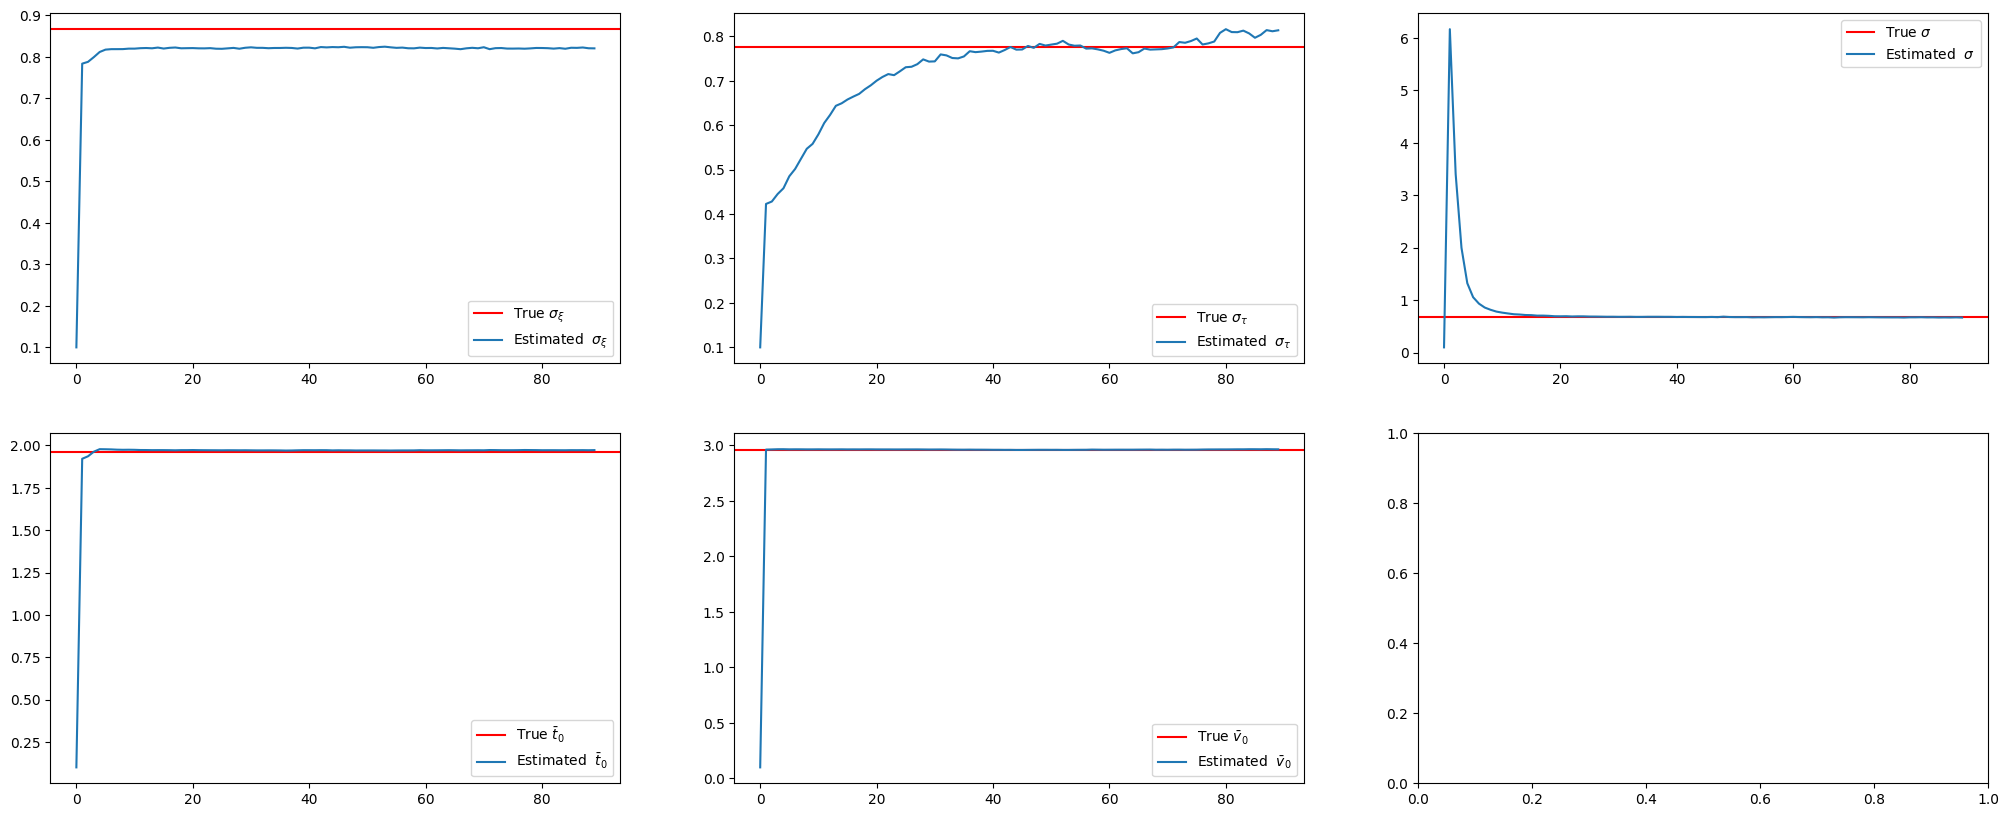

 50%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 100/200 [10:18<10:17,  6.17s/it]

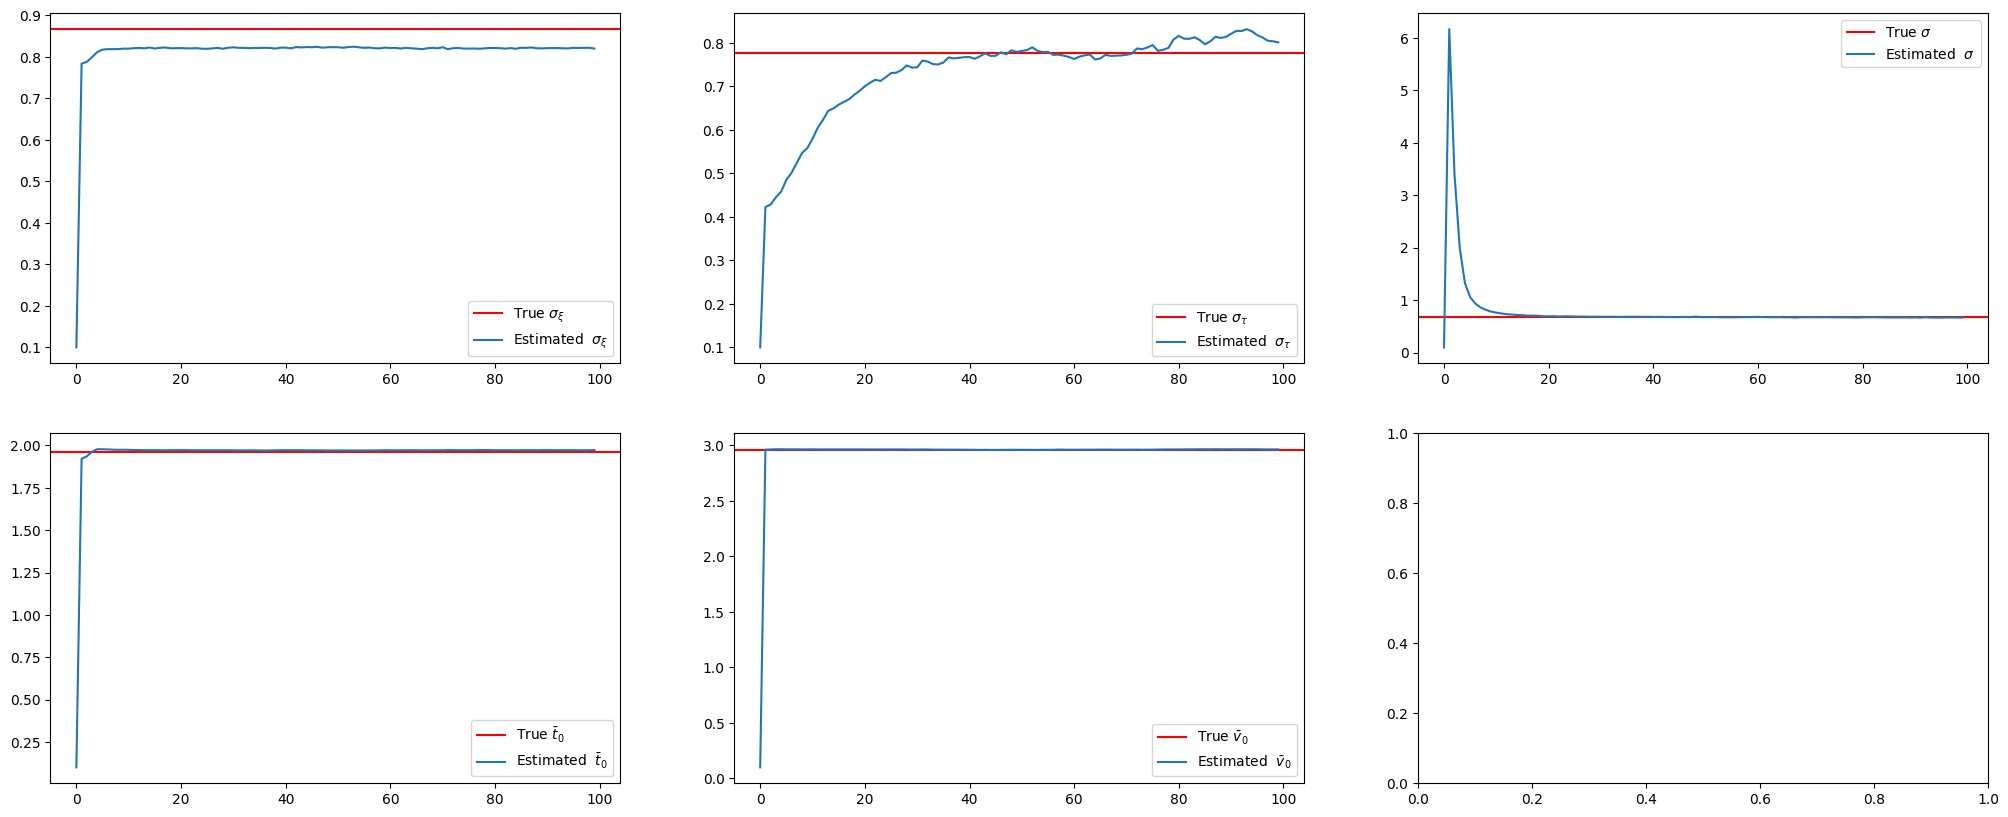

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 110/200 [11:21<09:12,  6.14s/it]

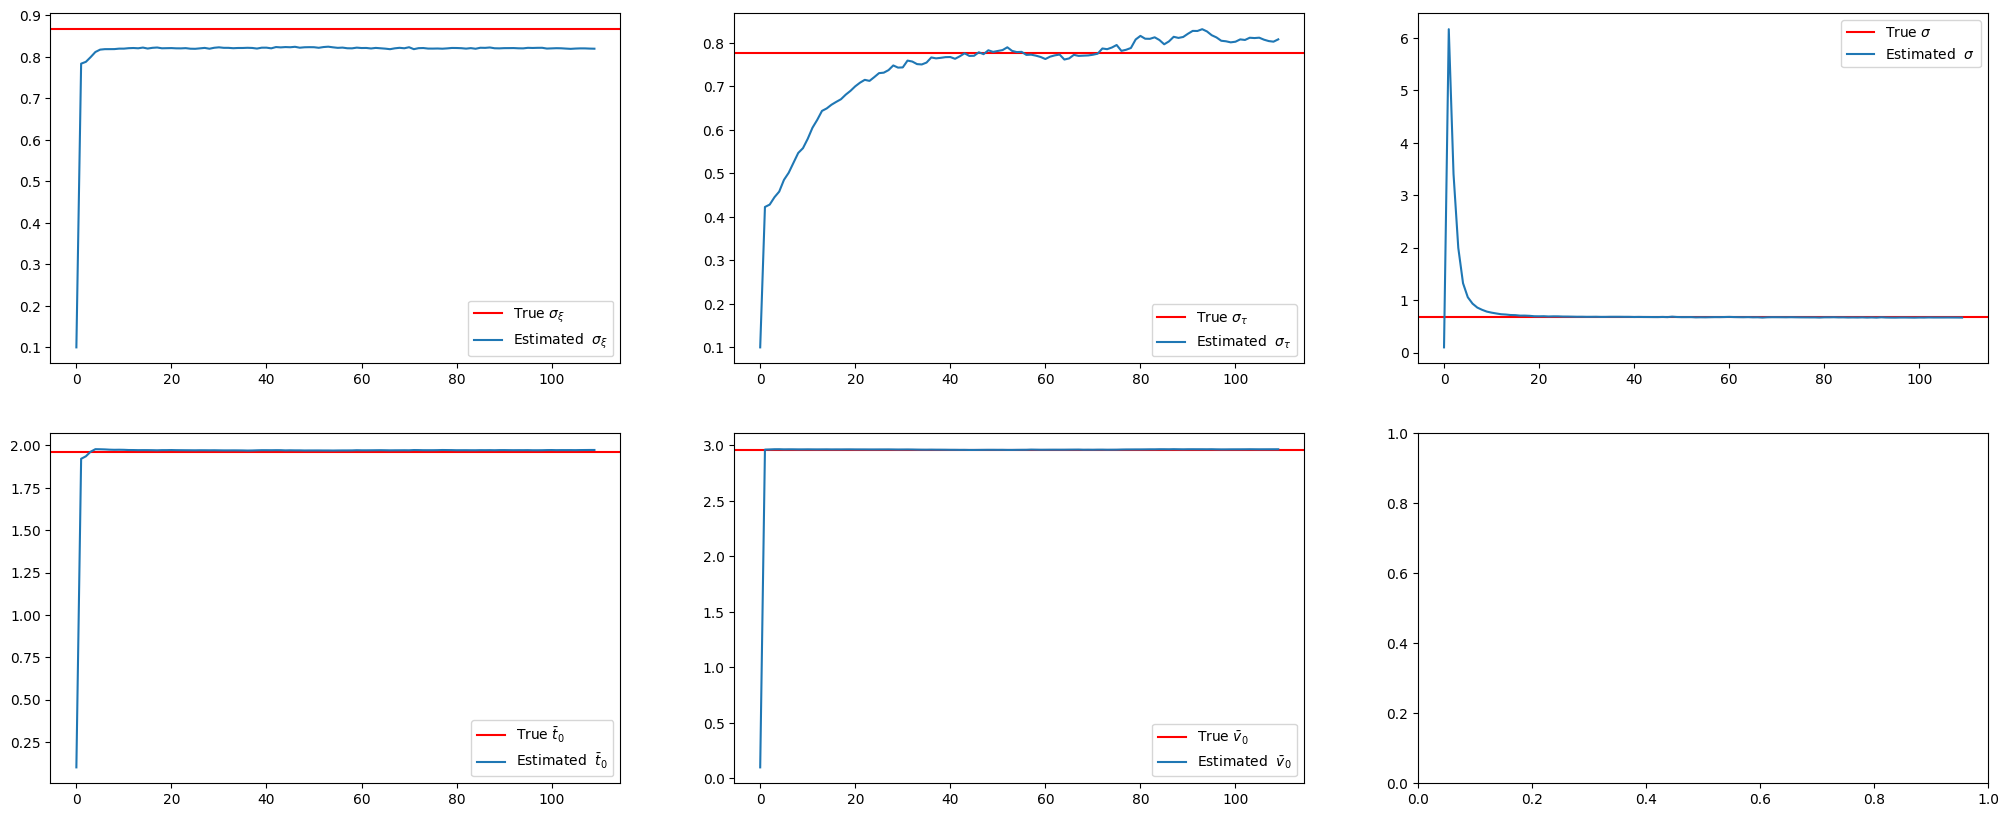

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 120/200 [12:23<08:21,  6.27s/it]

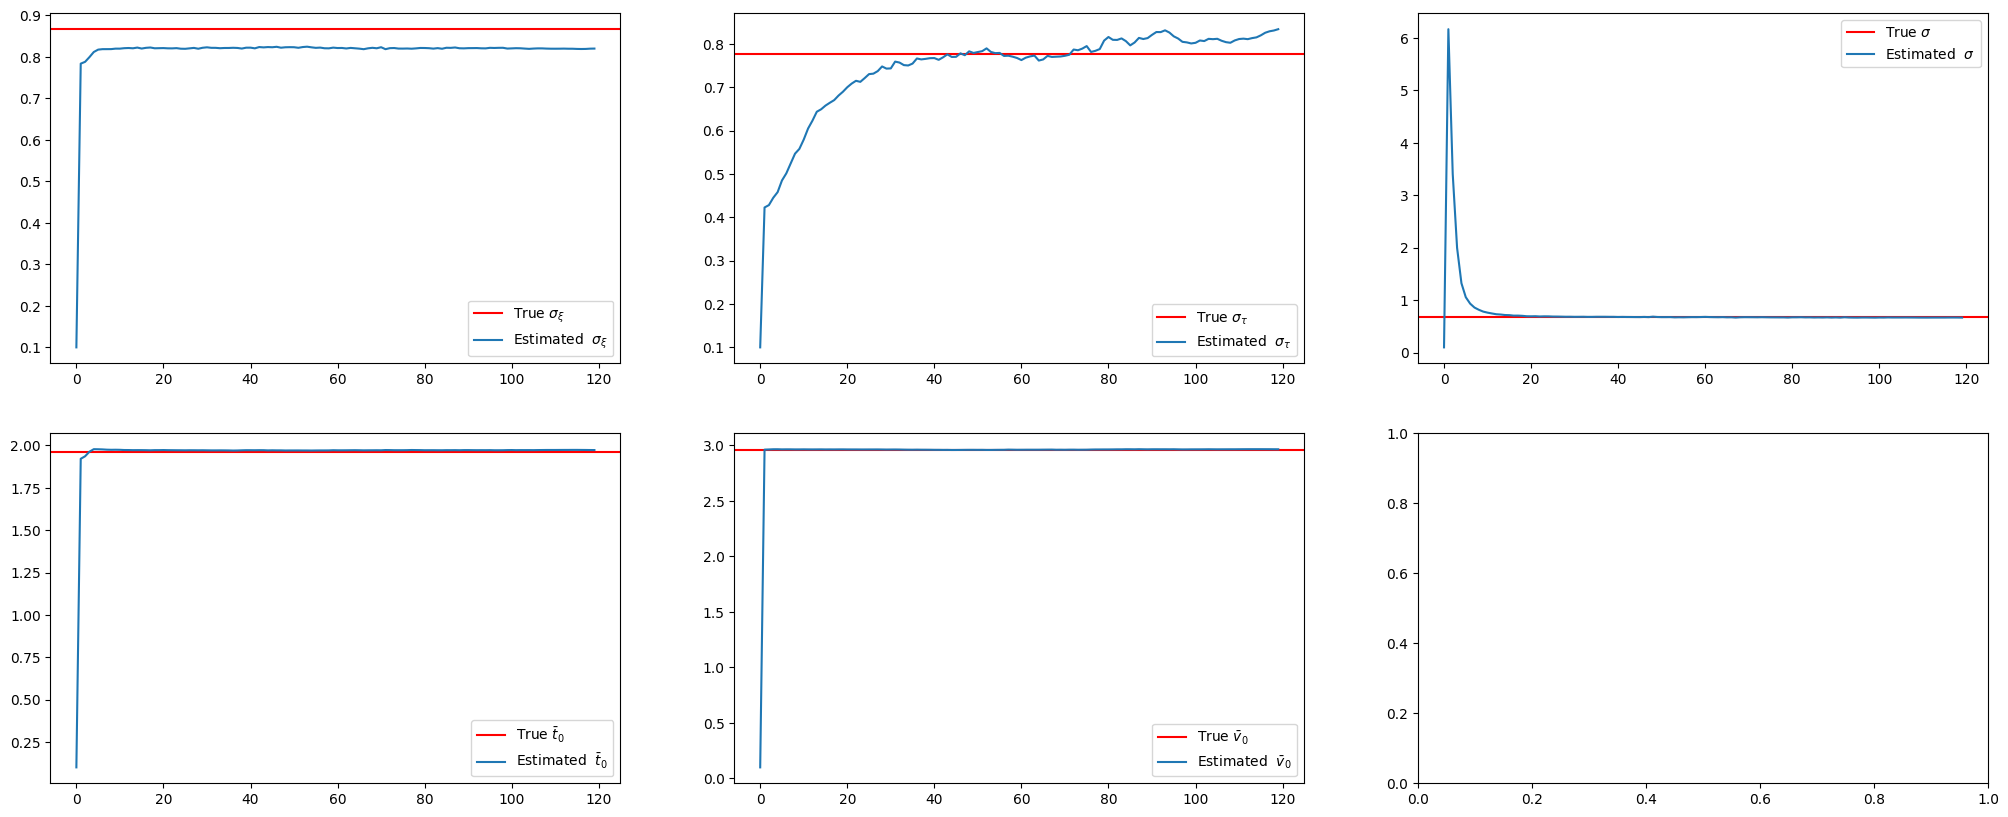

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 130/200 [13:25<07:12,  6.17s/it]

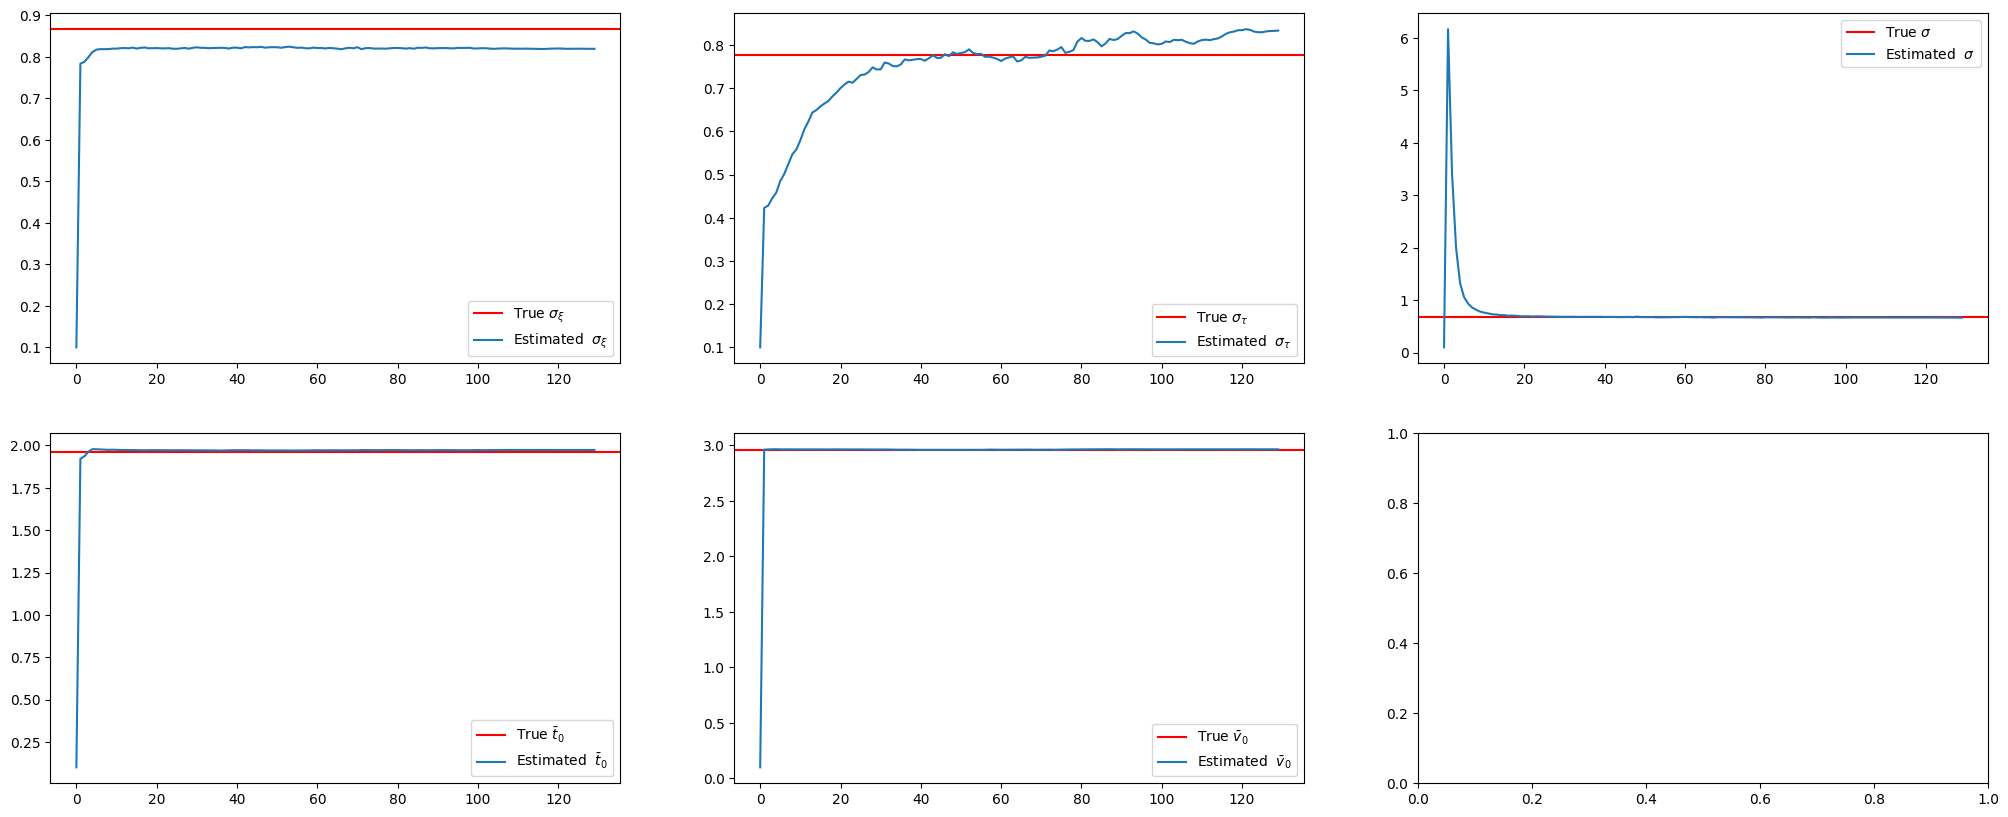

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 140/200 [14:27<06:13,  6.23s/it]

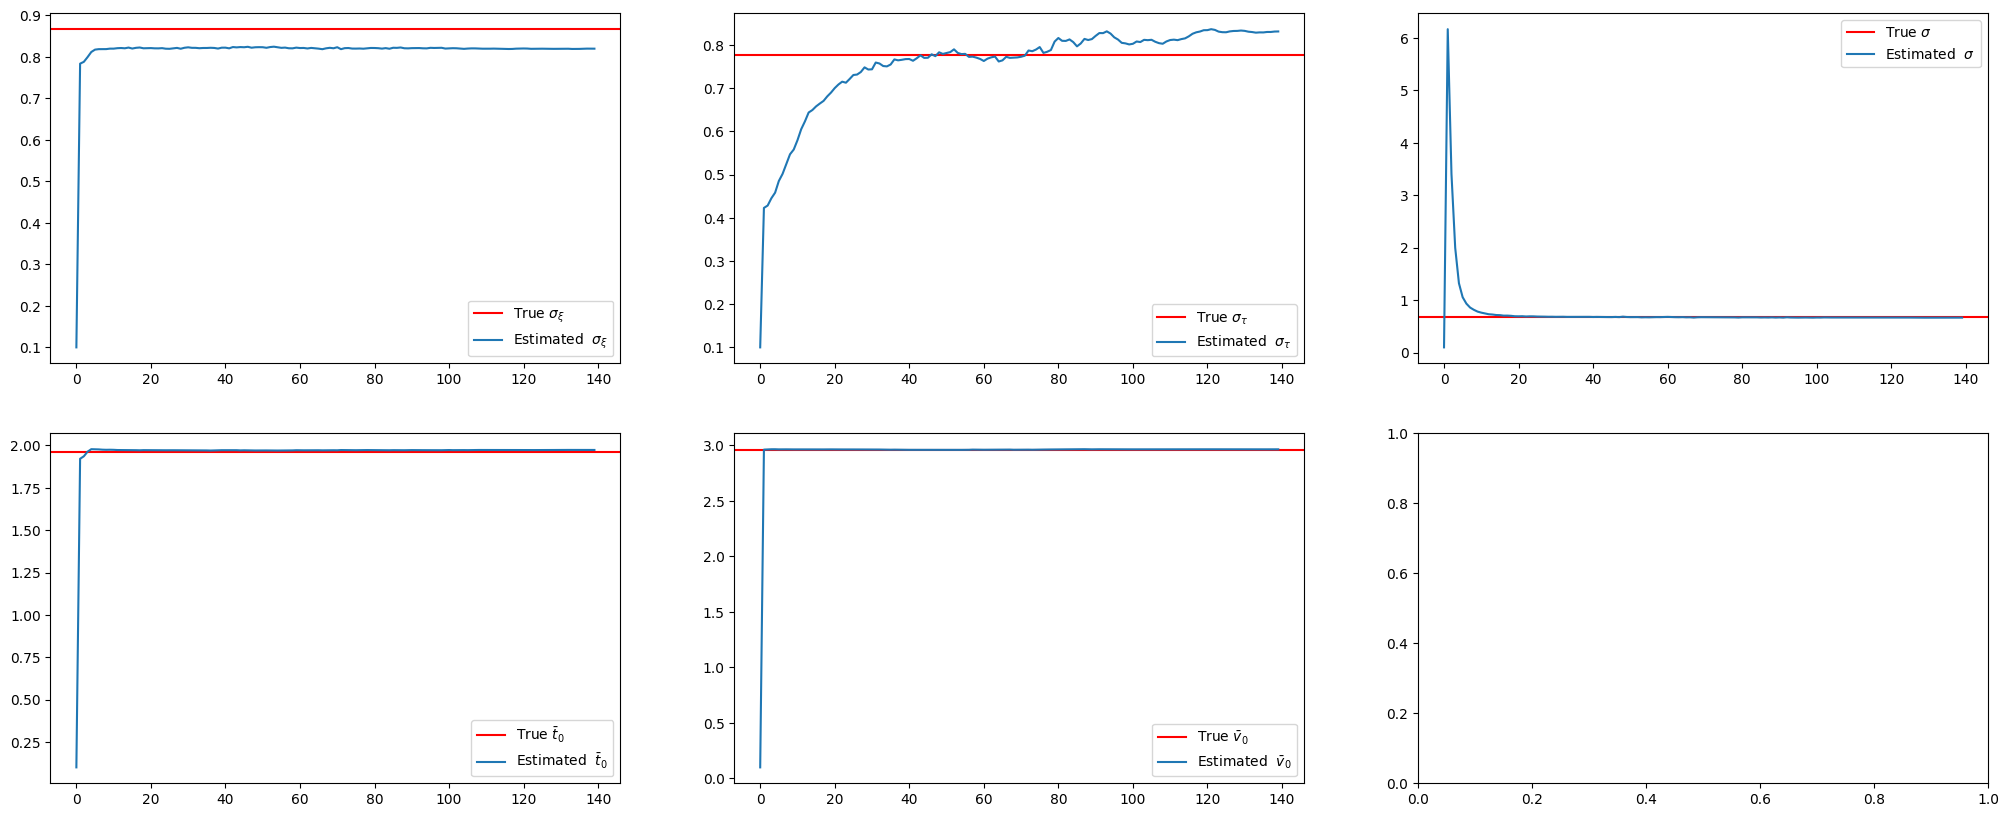

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 150/200 [15:30<05:10,  6.20s/it]

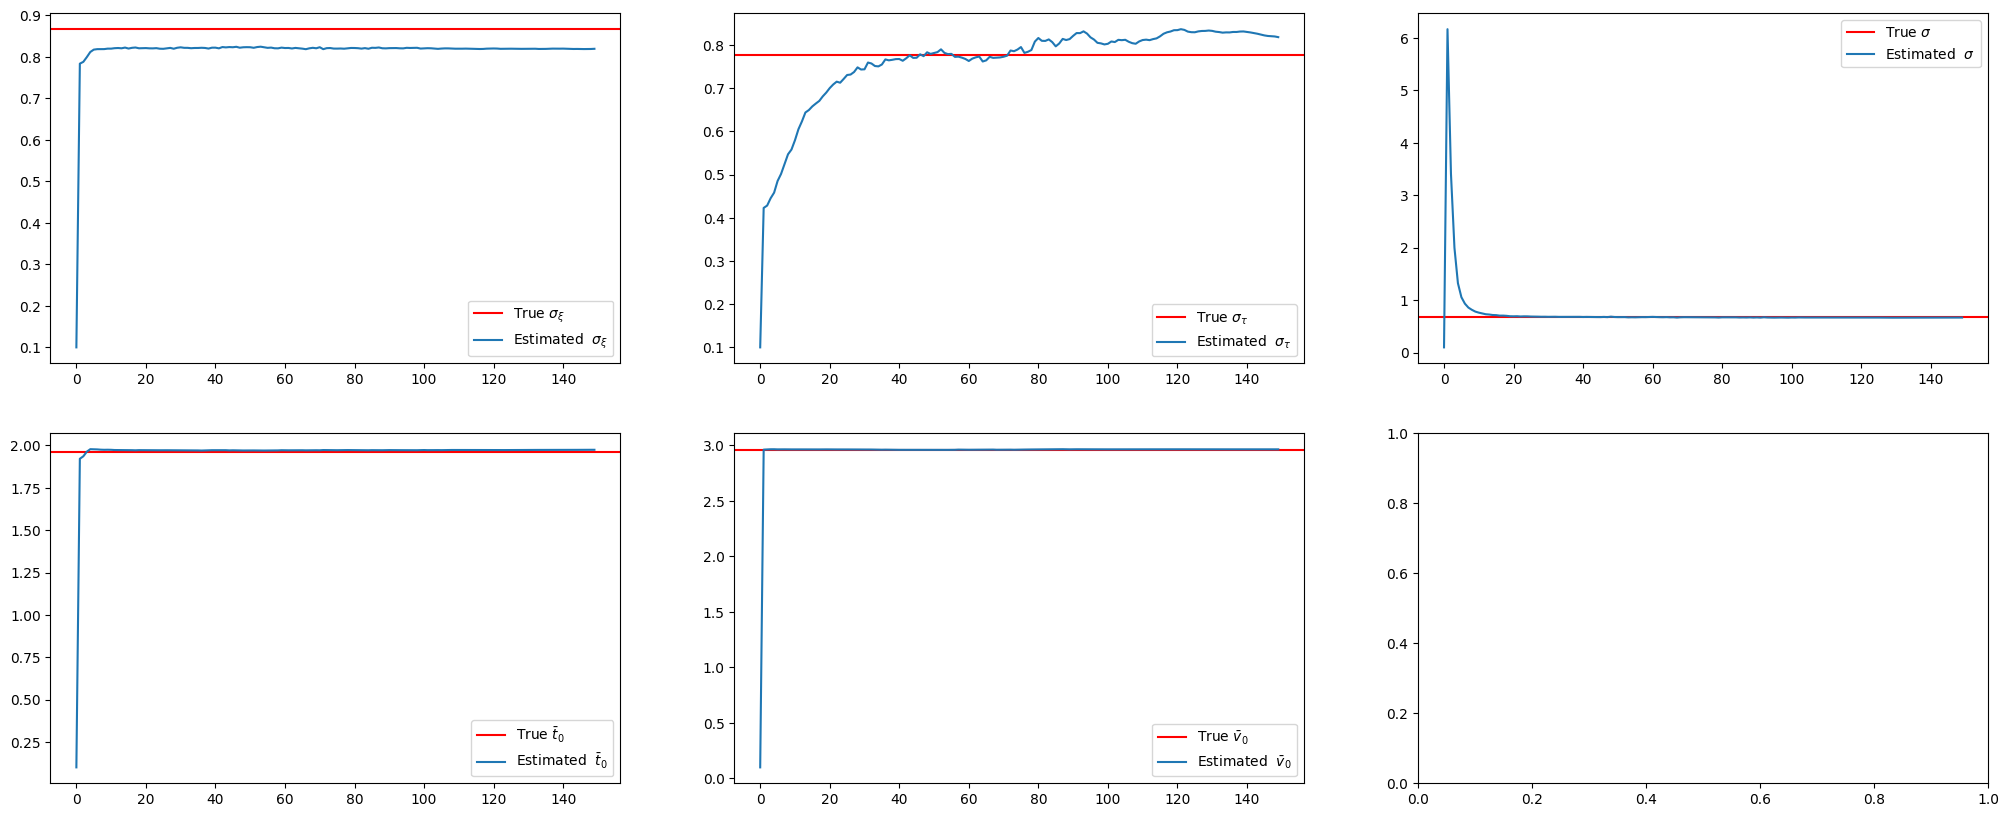

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 160/200 [16:32<04:10,  6.26s/it]

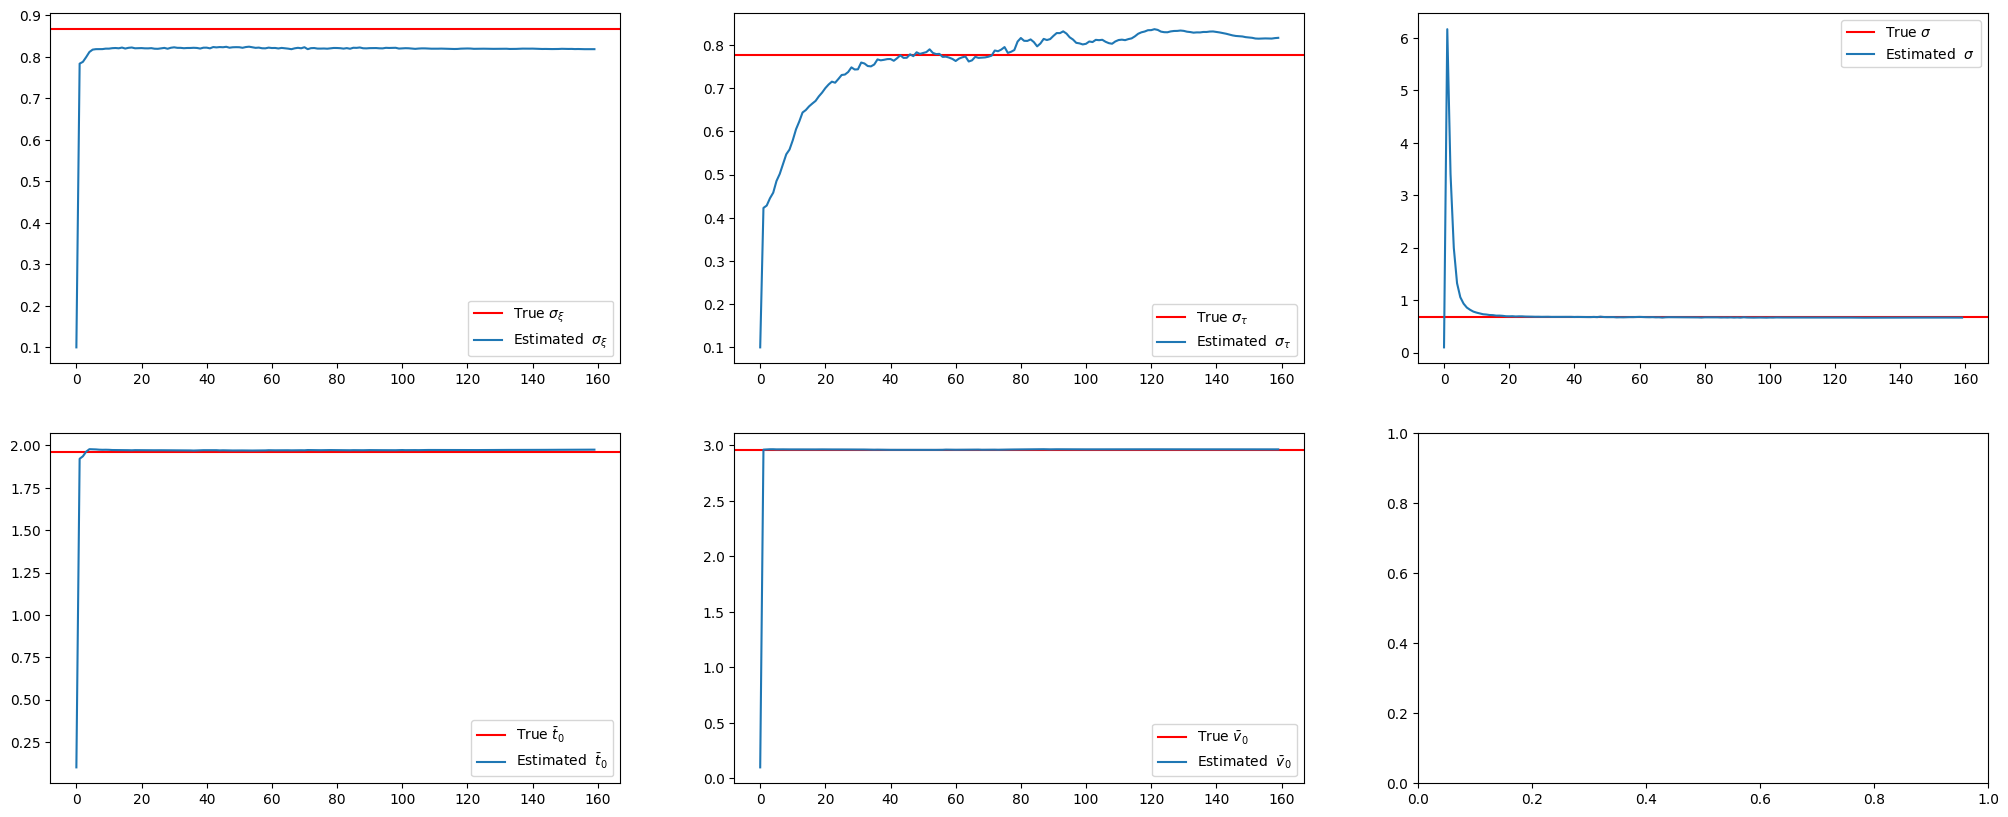

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 170/200 [17:35<03:03,  6.13s/it]

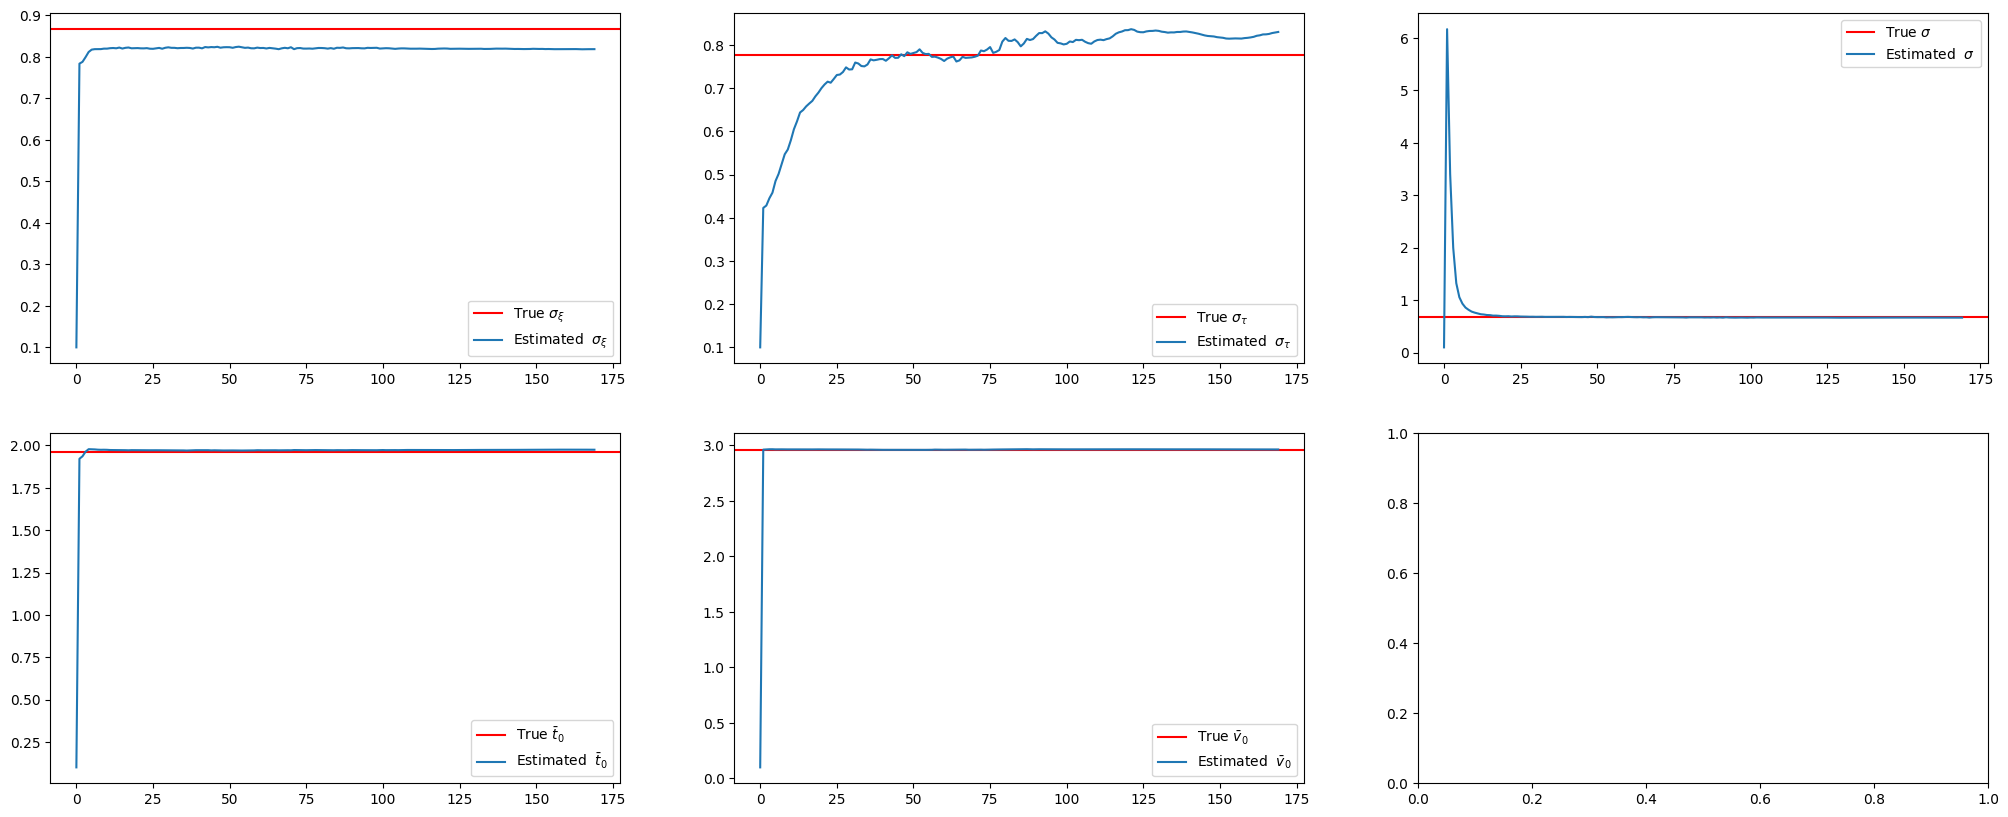

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 180/200 [18:37<02:03,  6.17s/it]

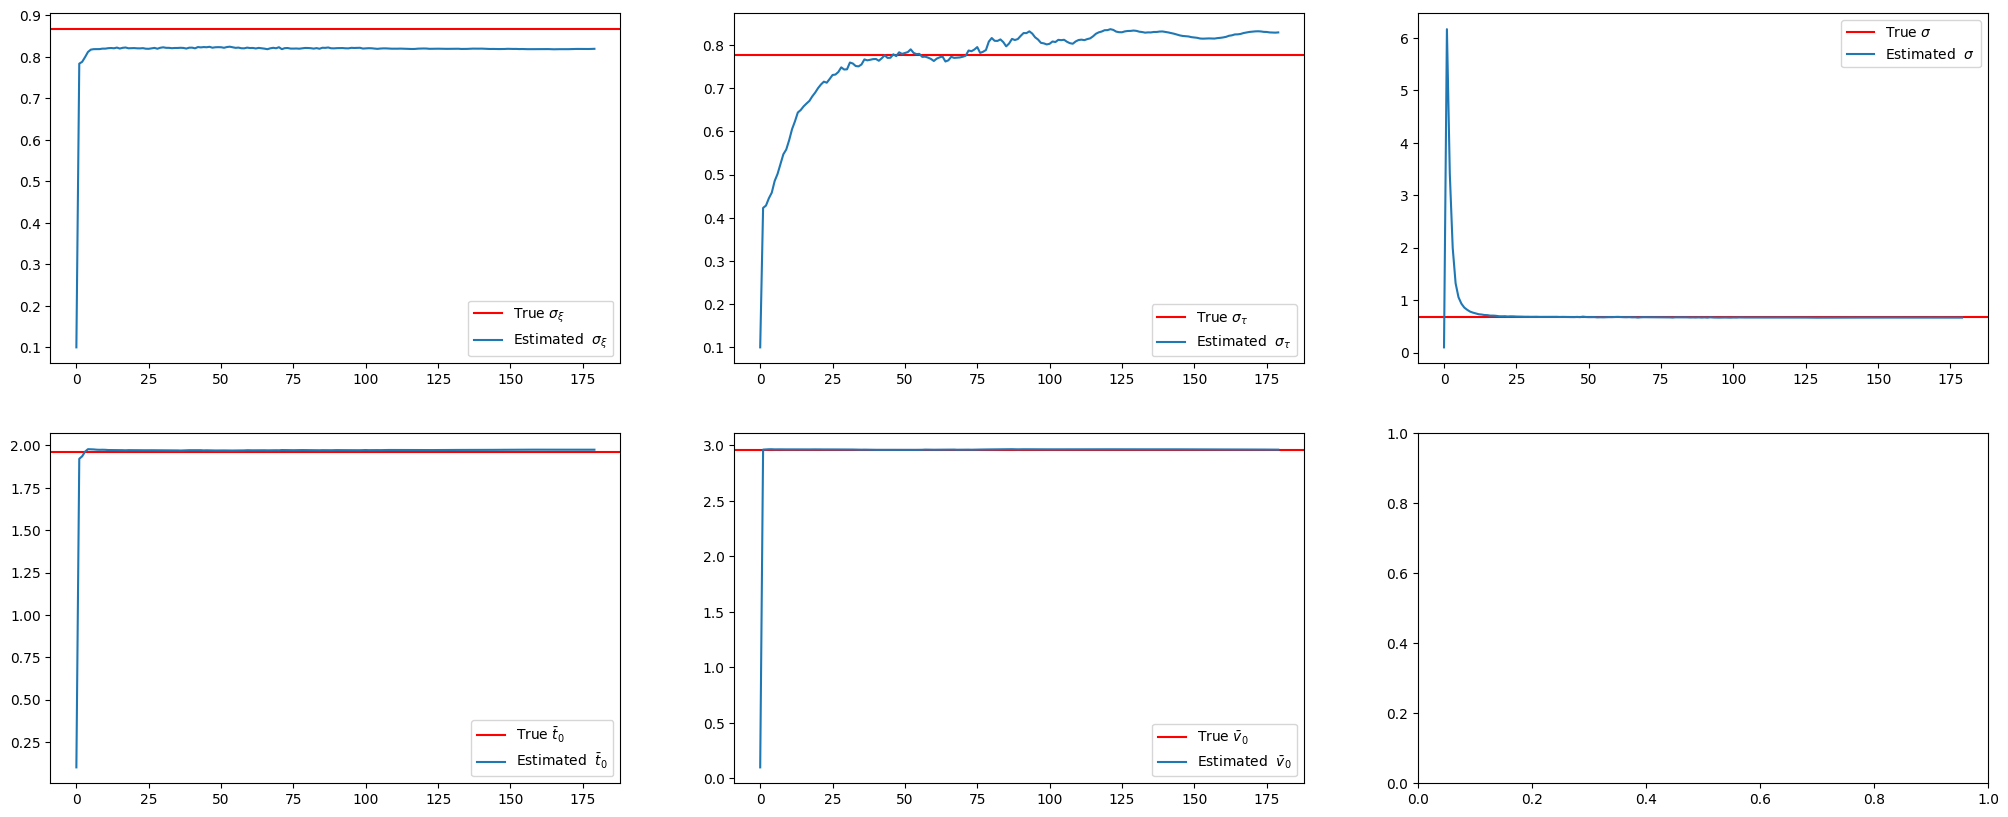

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 190/200 [19:40<01:01,  6.15s/it]

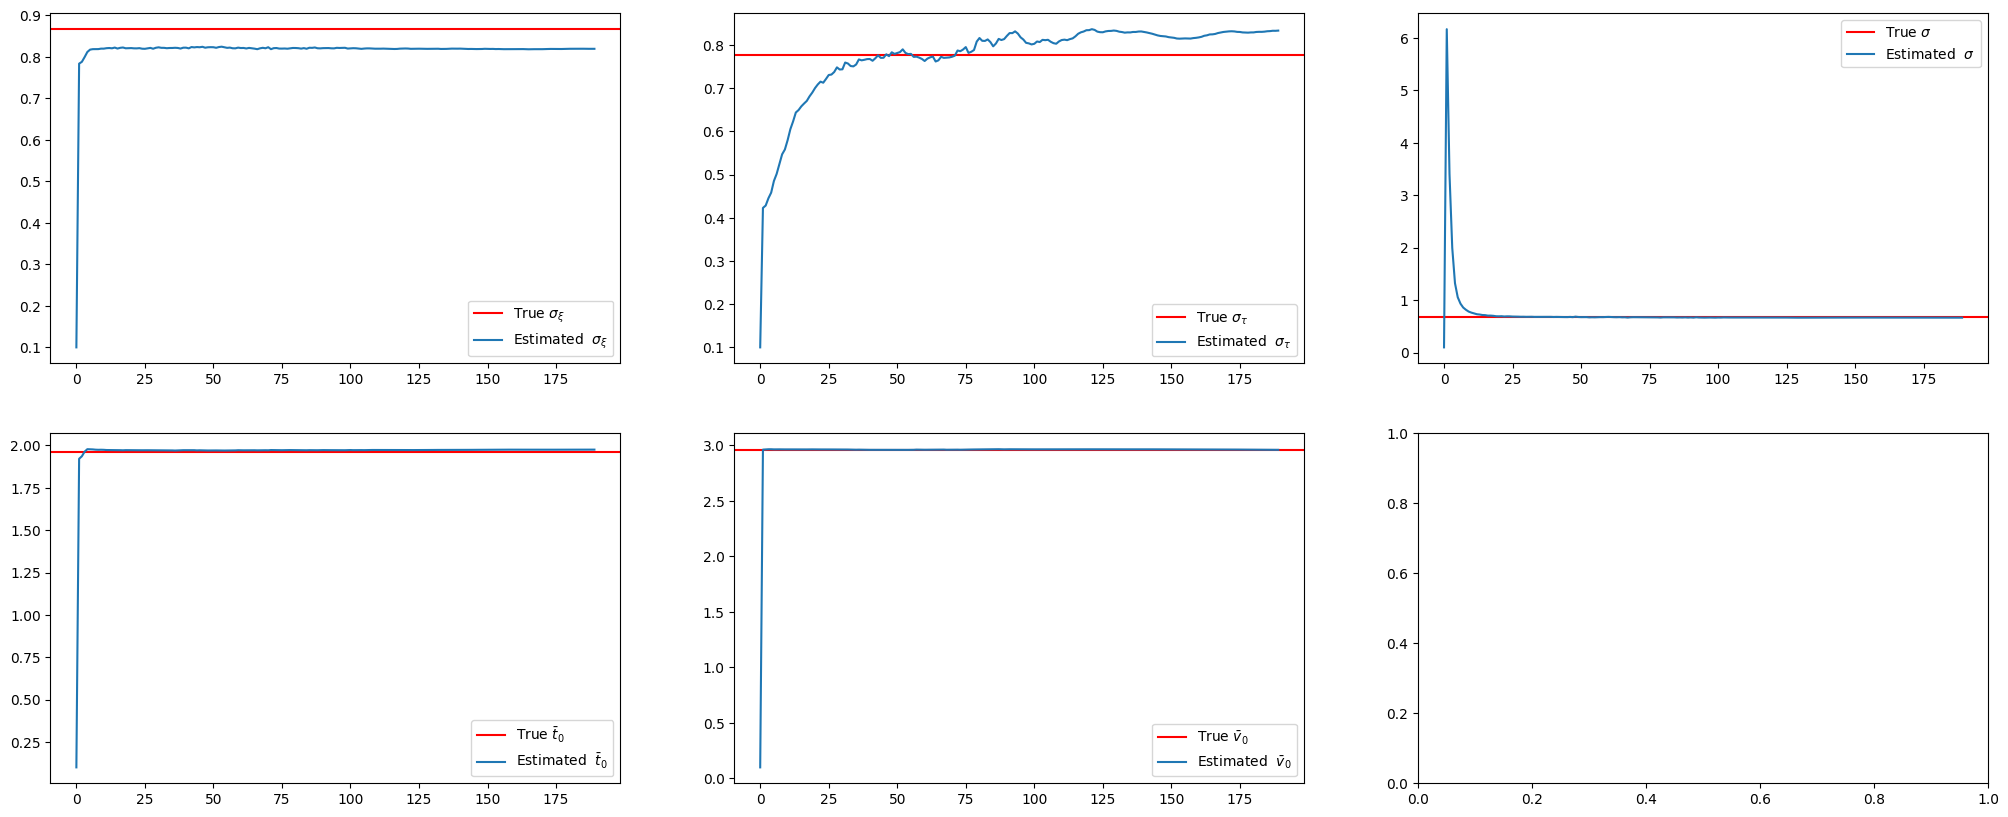

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [20:42<00:00,  6.21s/it]


In [1878]:
Gibbs_SAEM.train()

Text(0.5, 1.0, '$\\tau_i$: sampled from Gibbs-MCMC-SAEM $\\theta$ VS. MCMC-SAME $ \\theta$')

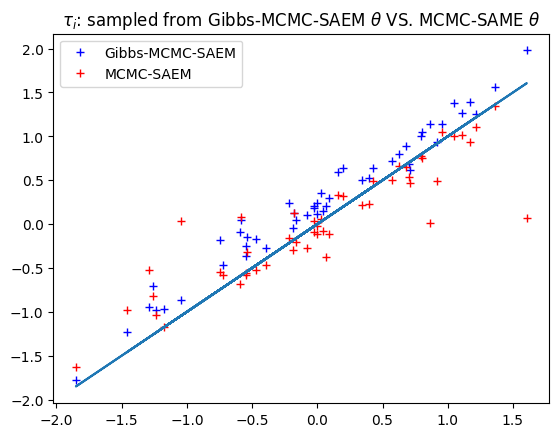

In [1886]:
plt.plot(data.z[N:2*N],Gibbs_SAEM.z[N:2*N], '+b',  label = "Gibbs-MCMC-SAEM")
plt.plot(data.z[N:2*N],SAEM2.z[N:2*N], '+r', label = "MCMC-SAEM")
plt.plot(data.z[N:2*N],data.z[N:2*N])
plt.legend()
plt.title(r"$\tau_i$: sampled from Gibbs-MCMC-SAEM $\theta$ VS. MCMC-SAEM $ \theta$")

Text(0.5, 1.0, '$\\xi_i$: sampled from Gibbs-MCMC-SAEM $\\theta$ VS. MCMC-SAEM $ \\theta$')

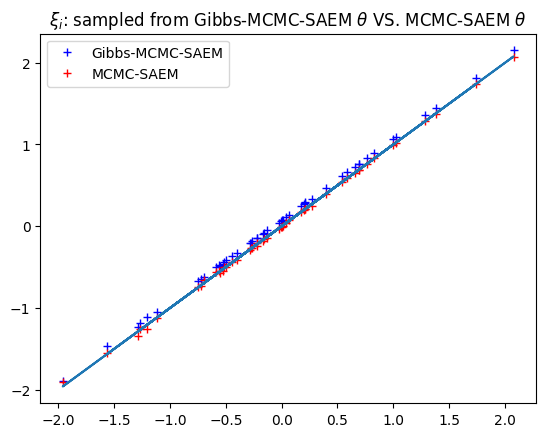

In [1887]:
plt.plot(data.z[:N],Gibbs_SAEM.z[:N], '+b',  label = "Gibbs-MCMC-SAEM")
plt.plot(data.z[:N],SAEM2.z[:N], '+r',  label = "MCMC-SAEM")
plt.plot(data.z[:N],data.z[:N])
plt.legend()
plt.title(r"$\xi_i$: sampled from Gibbs-MCMC-SAEM $\theta$ VS. MCMC-SAEM $ \theta$")

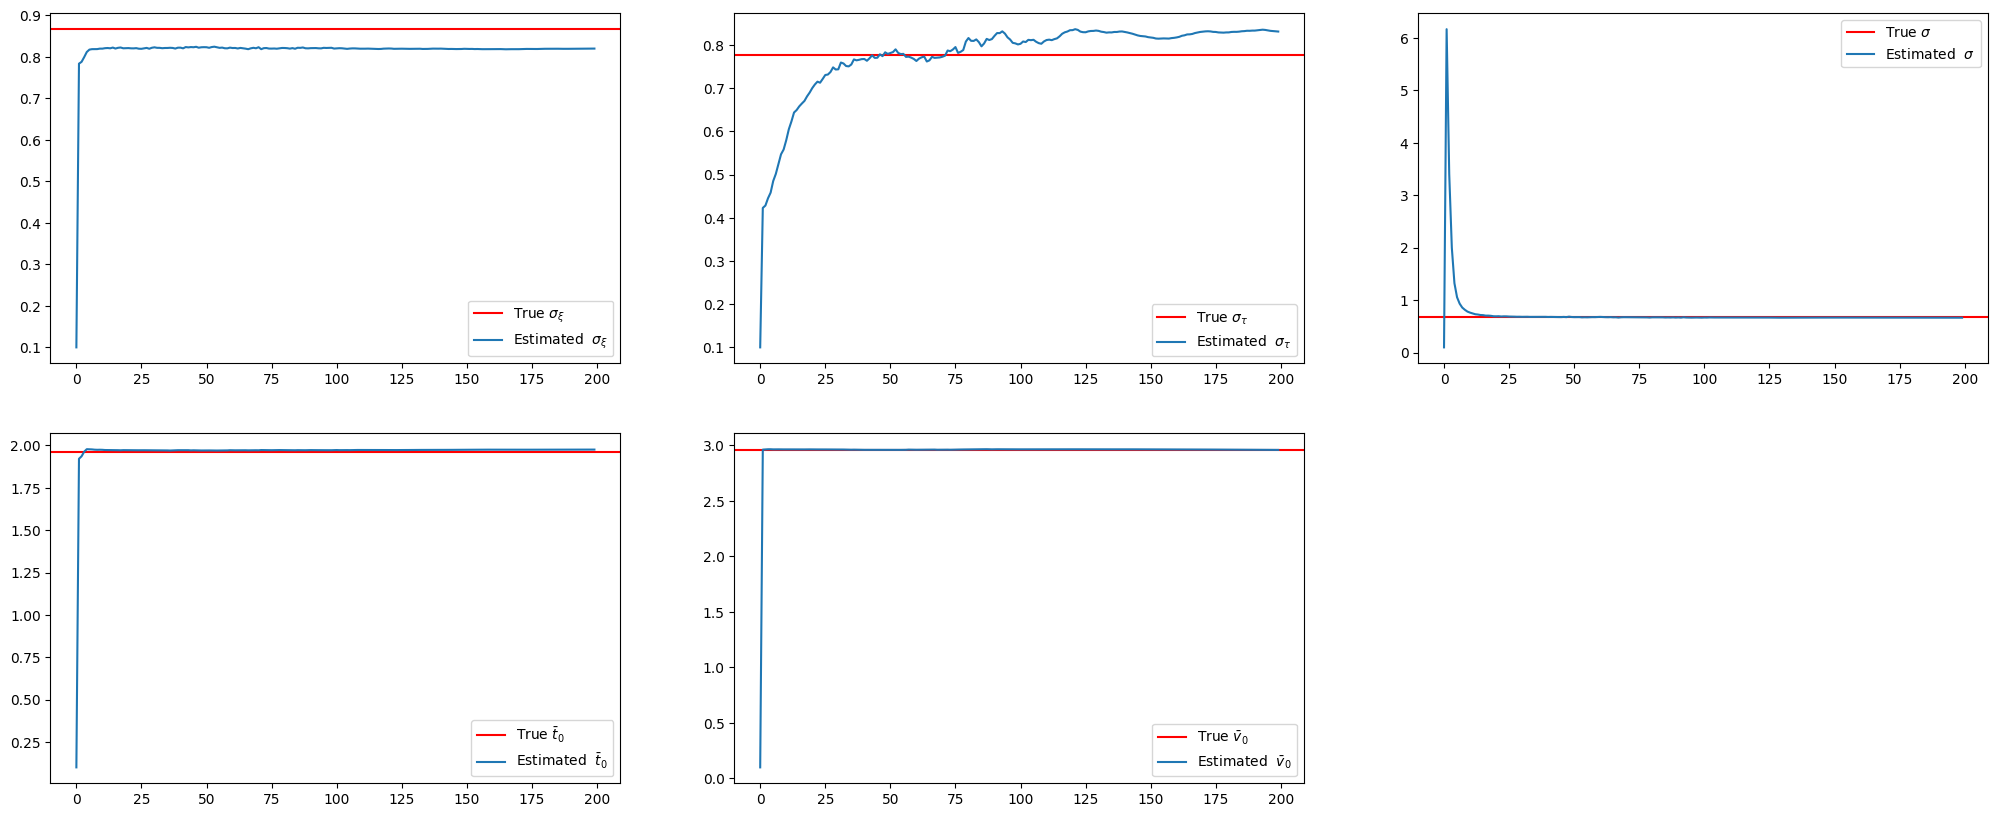

In [1881]:
fig, axs = plt.subplots(2, 3,  figsize=(25, 10))
x= range(Gibbs_SAEM.nstep)
axs[0, 0].axhline(y=data.theta[0], color='r', linestyle='-', label = r"True $\sigma_\xi$")
axs[0, 0].plot(x, [Gibbs_SAEM.theta_list[k][0] for k in x],label = r"Estimated  $\sigma_\xi$")
axs[0, 0].legend()
axs[0, 1].axhline(y=data.theta[1], color='r', linestyle='-', label = r"True $\sigma_\tau$")
axs[0, 1].plot(x, [Gibbs_SAEM.theta_list[k][1] for k in x],label = r"Estimated  $\sigma_\tau$")
axs[0, 1].legend()
axs[0, 2].axhline(y=data.theta[2], color='r', linestyle='-', label = r"True $\sigma$")
axs[0, 2].plot(x, [Gibbs_SAEM.theta_list[k][2] for k in x],label = r"Estimated  $\sigma$")
axs[0, 2].legend()
axs[1, 0].axhline(y=data.theta[3], color='r', linestyle='-', label = r"True $\bar t_0$")
axs[1, 0].plot(x, [Gibbs_SAEM.theta_list[k][3] for k in x],label = r"Estimated  $\bar t_0$")
axs[1, 0].legend()
axs[1, 1].axhline(y=data.theta[4], color='r', linestyle='-', label = r"True $\bar v_0$")
axs[1, 1].plot(x, [Gibbs_SAEM.theta_list[k][4] for k in x],label = r"Estimated  $\bar v_0$")
axs[1, 1].legend()
axs[1,2].axis("off")
plt.show()

n 4999 [0.81949415 0.67012199 0.68250008 1.98465191 2.96550022]


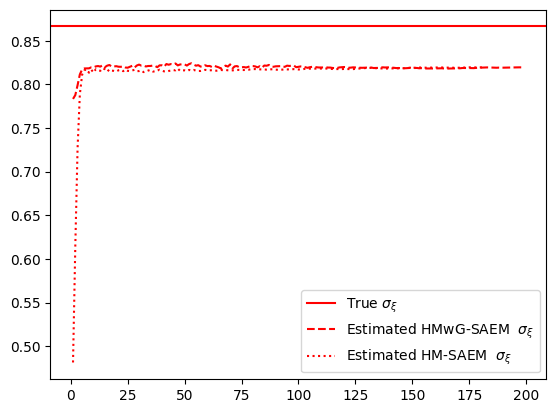

In [1894]:
print("n",n,SAEM2.theta)



plt.axhline(y=data.theta[0], color='r', linestyle='-', label = r"True $\sigma_\xi$")
plt.plot(range(1,Gibbs_SAEM.nstep), [Gibbs_SAEM.theta_list[k][0] for k in range(1,Gibbs_SAEM.nstep)],color='r',linestyle='--',label = r"Estimated HMwG-SAEM  $\sigma_\xi$")
plt.plot(range(1,SAEM2.nstep), [SAEM2.theta_list[k][0] for k in range(1,SAEM2.nstep)],color='r',linestyle='dotted',label = r"Estimated HM-SAEM  $\sigma_\xi$")
plt.legend()
plt.show()







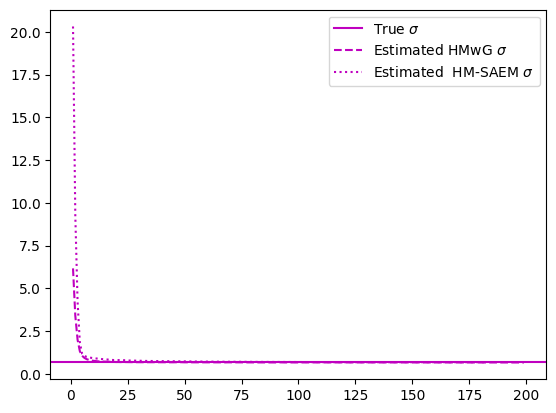

In [1891]:
plt.axhline(y=data.theta[2], color='m', linestyle='-', label = r"True $\sigma$")
plt.plot(range(1,Gibbs_SAEM.nstep), [Gibbs_SAEM.theta_list[k][2] for k in range(1,Gibbs_SAEM.nstep)],color='m',linestyle='--',label = r"Estimated HMwG $\sigma$")
plt.plot(range(1,SAEM2.nstep), [SAEM2.theta_list[k][2] for k in range(1,SAEM2.nstep)],color='m',linestyle='dotted',label = r"Estimated  HM-SAEM $\sigma$")

plt.legend()
plt.show()

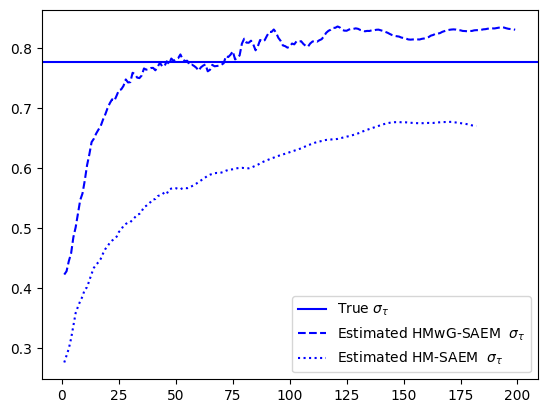

In [1888]:
plt.axhline(y=data.theta[1], color='b', linestyle='-', label = r"True $\sigma_\tau$")
plt.plot(range(1,Gibbs_SAEM.nstep), [Gibbs_SAEM.theta_list[k][1] for k in range(1,Gibbs_SAEM.nstep)],color='b',linestyle='--',label = r"Estimated HMwG-SAEM  $\sigma_\tau$")

plt.plot(range(1,SAEM2.nstep), [SAEM2.theta_list[k][1] for k in range(1,SAEM2.nstep)],color='b',linestyle='dotted',label = r"Estimated HM-SAEM  $\sigma_\tau$")

plt.legend()
plt.show()

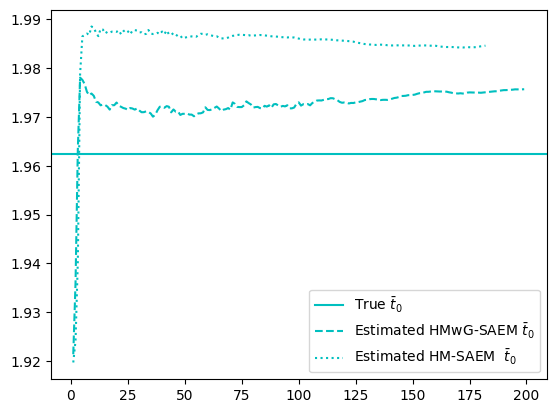

In [1890]:
plt.axhline(y=data.theta[3], color='c', linestyle='-', label = r"True $\bar t_0$")
plt.plot(range(1,Gibbs_SAEM.nstep), [Gibbs_SAEM.theta_list[k][3] for k in range(1,Gibbs_SAEM.nstep)],color='c',linestyle='--',label = r"Estimated HMwG-SAEM $\bar t_0$")

plt.plot(range(1,SAEM2.nstep), [SAEM2.theta_list[k][3] for k in range(1,SAEM2.nstep)],color='c',linestyle='dotted',label = r"Estimated HM-SAEM  $\bar t_0$")

plt.legend()
plt.show()

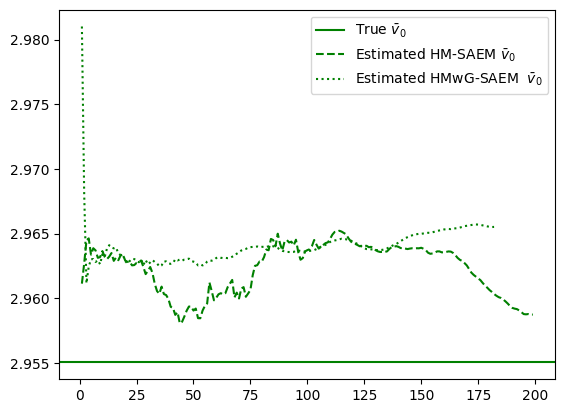

In [1889]:
plt.axhline(y=data.theta[4], color='g', linestyle='-', label = r"True $\bar v_0$")
plt.plot(range(1,Gibbs_SAEM.nstep), [Gibbs_SAEM.theta_list[k][4] for k in range(1,Gibbs_SAEM.nstep)],color='g',linestyle='--',label = r"Estimated HM-SAEM $\bar v_0$")
plt.plot(range(1,SAEM2.nstep), [SAEM2.theta_list[k][4] for k in range(1,SAEM2.nstep)],color='g',linestyle='dotted',label = r"Estimated HMwG-SAEM  $\bar v_0$")

plt.legend()
plt.show()

### Conclusion

On a comme prévu des résultats sensiblement meilleurs avec l'utilisation de Gibbs (donc en optimisant variable par variable de$z$).

# <span style="color:Gray"> Exercise 2: Multiplicative Hasting-Metropolis </span>

We use a uniform law on $[-1,1]$ to sample $\epsilon$.

### First target distribution: loi exponentielle de paramètre $\lambda>0$

In [827]:
lambd = 0.4

def exponential_sampling():
    u = np.random.rand()
    return -1./lambd * np.log(u)

def exponential_pdf(x):
    if x>=0:
        return lambd * np.exp(-lambd*x)
    else: return 0
    
class MultiplicativeHM_1D:
    def __init__(self, target_distrib, maxSteps = 15000):
        self.target = target_distrib
        self.max_steps = maxSteps
        self.z = 0.1
        self.z_list = []
        self.n_step = 0
        
    def step(self):
        epsilon = 2 * np.random.rand() - 1
        while epsilon == 0 :
            epsilon = 2 * np.random.rand() - 1
        bern = np.random.rand()
        if bern <= 0.5:
            y = epsilon * self.z
            u = np.random.rand()
            a= abs(epsilon) * self.target(y)/self.target(self.z)
            if u <= abs(epsilon) * self.target(y)/self.target(self.z):
                self.z = y
        else: 
            y = self.z / epsilon
            u = np.random.rand()
            if u <=  self.target(y)/(self.target(self.z)*abs(epsilon)):
                self.z = y
                
    def train(self):
        for n in range(self.max_steps):
            self.step()
            self.n_step +=1
            self.z_list.append(self.z)


In [828]:
MHM = MultiplicativeHM_1D(exponential_pdf)
MHM.train()

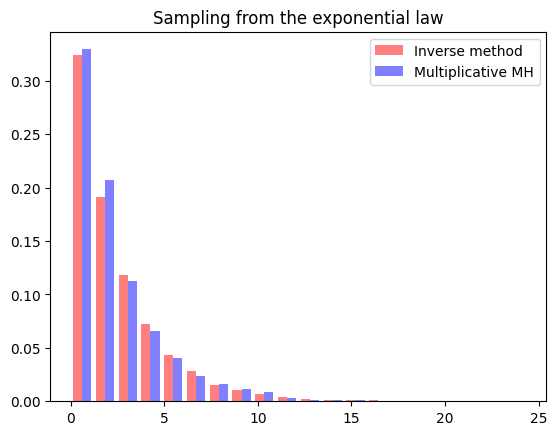

In [829]:
inverse_method_sampling = [ exponential_sampling() for k in range(20000)]
burning_steps = 1000
plt.hist([inverse_method_sampling,MHM.z_list[burning_steps:]], color=['r','b'], label = ["Inverse method", "Multiplicative MH"],density = True, bins=20, alpha=0.5)
plt.title("Sampling from the exponential law")
plt.legend()

### Second target distribution: Gaussian mixture

In [819]:
norm1 = norm(1,2)
norm2 = norm(10,1)

def gaussian_mixture_pdf(x):
    
    return 0.3 * norm1.pdf(x) + 0.7 * norm2.pdf(x)

def gaussian_mixture_sampling():
    u = np.random.rand()
    if u <= 0.3:
        return np.random.normal(1,2)
    else: return np.random.normal(10,1)

In [823]:
MHM = MultiplicativeHM_1D(gaussian_mixture_pdf)
MHM.train()

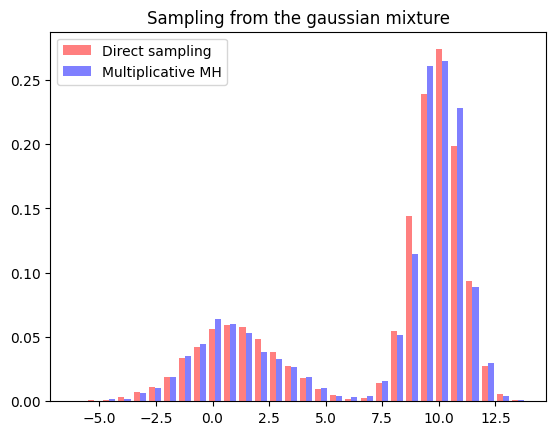

In [824]:
direct_sampling = [ gaussian_mixture_sampling() for k in range(20000)]
burning_steps = 1000
plt.hist([direct_sampling,MHM.z_list[burning_steps:]], color=['r','b'], label = ["Direct sampling", "Multiplicative MH"],density = True, alpha=0.5, bins=30)
plt.title("Sampling from the gaussian mixture")
plt.legend()

# <span style="color:Gray">  Exercise 3: Data augmentation </span>

### Question 3

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 391106.47it/s]


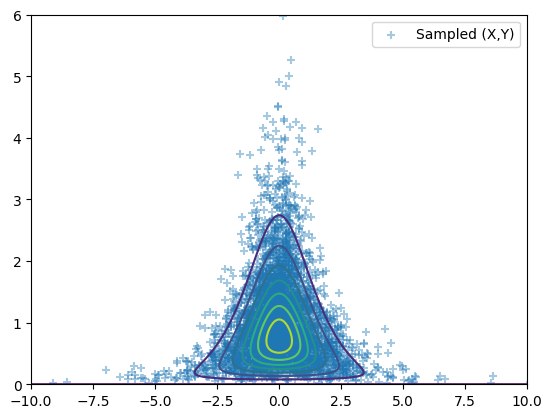

In [15]:
x = 0.1
y = 0.1

def joint_law(x,y):

    return 4./np.sqrt(2*np.pi) * y**(1.5) * np.exp(-y * (x**2/2.+2.))


x_list = []
x_list2 = []
y_list = []
for n in trange(5000):
    x = 1/np.sqrt(y) * np.random.randn()
    y = np.random.gamma(shape = 5./2., scale = 1/(x**2/2. + 2))
    x_list2.append(x)
    if n>= 1000:
        x_list.append(x)
        y_list.append(y)
        
plt.scatter(x_list,y_list, label = "Sampled (X,Y)", alpha = 0.4, marker='+')
x = np.linspace(-12, 12, 2000).reshape((2000,1))
y = np.linspace(0,6, 1000).reshape((1000,1))
X,Y = np.meshgrid(x,y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
z = joint_law(X,Y)
plt.contour(X,Y,z)
plt.xlim(-10,10)
plt.legend()
plt.show()


    

In [4]:
from scipy.special import gamma

In [5]:
gamma(5./2.)

1.329340388179137

### Question 4

On teste la valeur de intégrale pour 3 fonctions $H(x)$

1. $H_1(x)=\cos(x)+14$
2. $H_2(x)=x^3+10$
3. $H_3(x)=x^2$

In [6]:
def h_test1(x):
    return np.cos(x)+14
def h_test2(x):
    return x**3+10
def h_test3(x):
    return x**2
result1 =  1/16 * np.sqrt(np.pi) * (1/gamma(5./2.)) * h_test1(np.array(x_list)).mean()
result2 =  1/16 * np.sqrt(np.pi) * (1/gamma(5./2.)) * h_test2(np.array(x_list)).mean()
result3 =  1/16 * np.sqrt(np.pi) * (1/gamma(5./2.)) * h_test3(np.array(x_list)).mean()
results = np.array([result1,result2,result3])
print("Values of integrals computed with Monte-Carlo and Gibbs sampling",results)

Values of integrals computed with Monte-Carlo and Gibbs sampling [1.20887361 0.82974939 0.16632357]


In [7]:
from scipy.integrate import quad   

true_result1 = quad(lambda x: h_test1(x)*((4+x**2)**(-5./2.)), -np.inf, np.inf)[0]
true_result2 = quad(lambda x: h_test2(x)*((4+x**2)**(-5./2.)), -np.inf, np.inf)[0]
true_result3 = quad(lambda x: h_test3(x)*((4+x**2)**(-5./2.)), -np.inf, np.inf)[0]
true_results = np.array([true_result1,true_result2,true_result3])
print("True values of integrals (computed from QUADPACK)",true_results)

True values of integrals (computed from QUADPACK) [1.20895996 0.83333333 0.16666667]


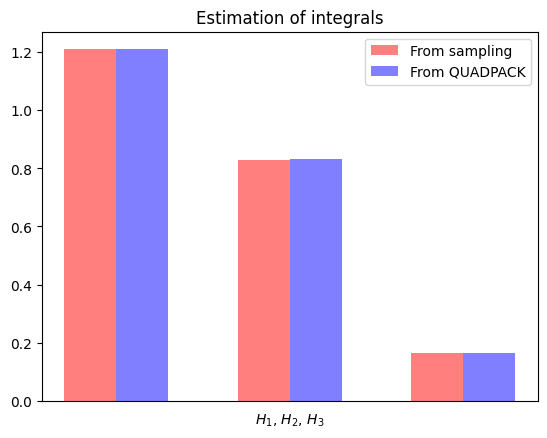

In [8]:
x = np.array([1,2,3])
w = 0.3
plt.bar(x-w, results, width=w, color='r',alpha=0.5, align='center', label = "From sampling")
plt.bar(x, true_results, width=w, color='b', alpha=0.5,align='center', label = "From QUADPACK")
plt.xlabel(r"$H_1$, $H_2$, $H_3$")
plt.title("Estimation of integrals")
plt.xticks([], [])
plt.legend()

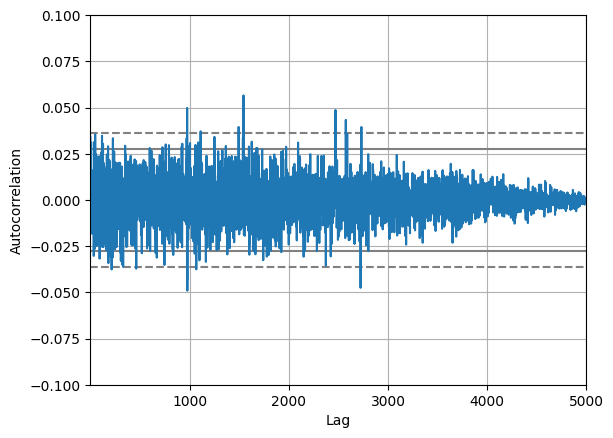

In [16]:
import pandas
x = pandas.plotting.autocorrelation_plot(x_list2)
x.plot()
plt.ylim(-0.1,0.1)
plt.title(r"Test independency of $(X_i)_i$ for the validity of expectation estimation")
plt.show()